# Experimental Data (Testing)

In [22]:
del images_train, images_test
torch.cuda.empty_cache()
gc.collect()

20634

In [81]:
base='Geo_5ulh_pre/'
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
files=os.listdir(base)

full_files=[]
sorted_frames = sorted(files, key=lambda x: int(x[3:-4]))
for i in range(len(sorted_frames)):
    file = base+sorted_frames[i]
    full_files.append(file)

In [82]:
#torch.cuda.empty_cache()
import gc
gc.collect()

16354

In [83]:
images_train.shape

torch.Size([556, 40, 448, 448])

# Load Test Images

In [84]:
full_files[0]

'Geo_5ulh_pre/tst0.tif'

In [85]:
import cv2
import numpy as np
import cv2
from joblib import Parallel, delayed
l=448
from PIL import Image
# def process_file(file_path):
#     image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
#     resized_image = cv2.resize(image, [l, l])
#     return resized_image
def process_file(file_path):
    image = np.array(Image.open(file_path))
    resized_image = cv2.resize(image, [l, l])
    resized_image = (resized_image-np.min(resized_image))/(np.max(resized_image)-np.min(resized_image))
    return resized_image

def parallel_image_processing(full_files):
    num_files = len(full_files)
    images = np.zeros([num_files, l, l])

    results = Parallel(n_jobs=16)(delayed(process_file)(file_path) for file_path in full_files)

    for i, resized_image in enumerate(results):
        images[i] = resized_image

    return images

images = parallel_image_processing(full_files)

In [46]:
# x,y = next(iter(test_dataloader))
# plt.imshow(x[-1,0,:,:])

In [86]:
import gc
gc.collect()
images.shape

(3200, 448, 448)

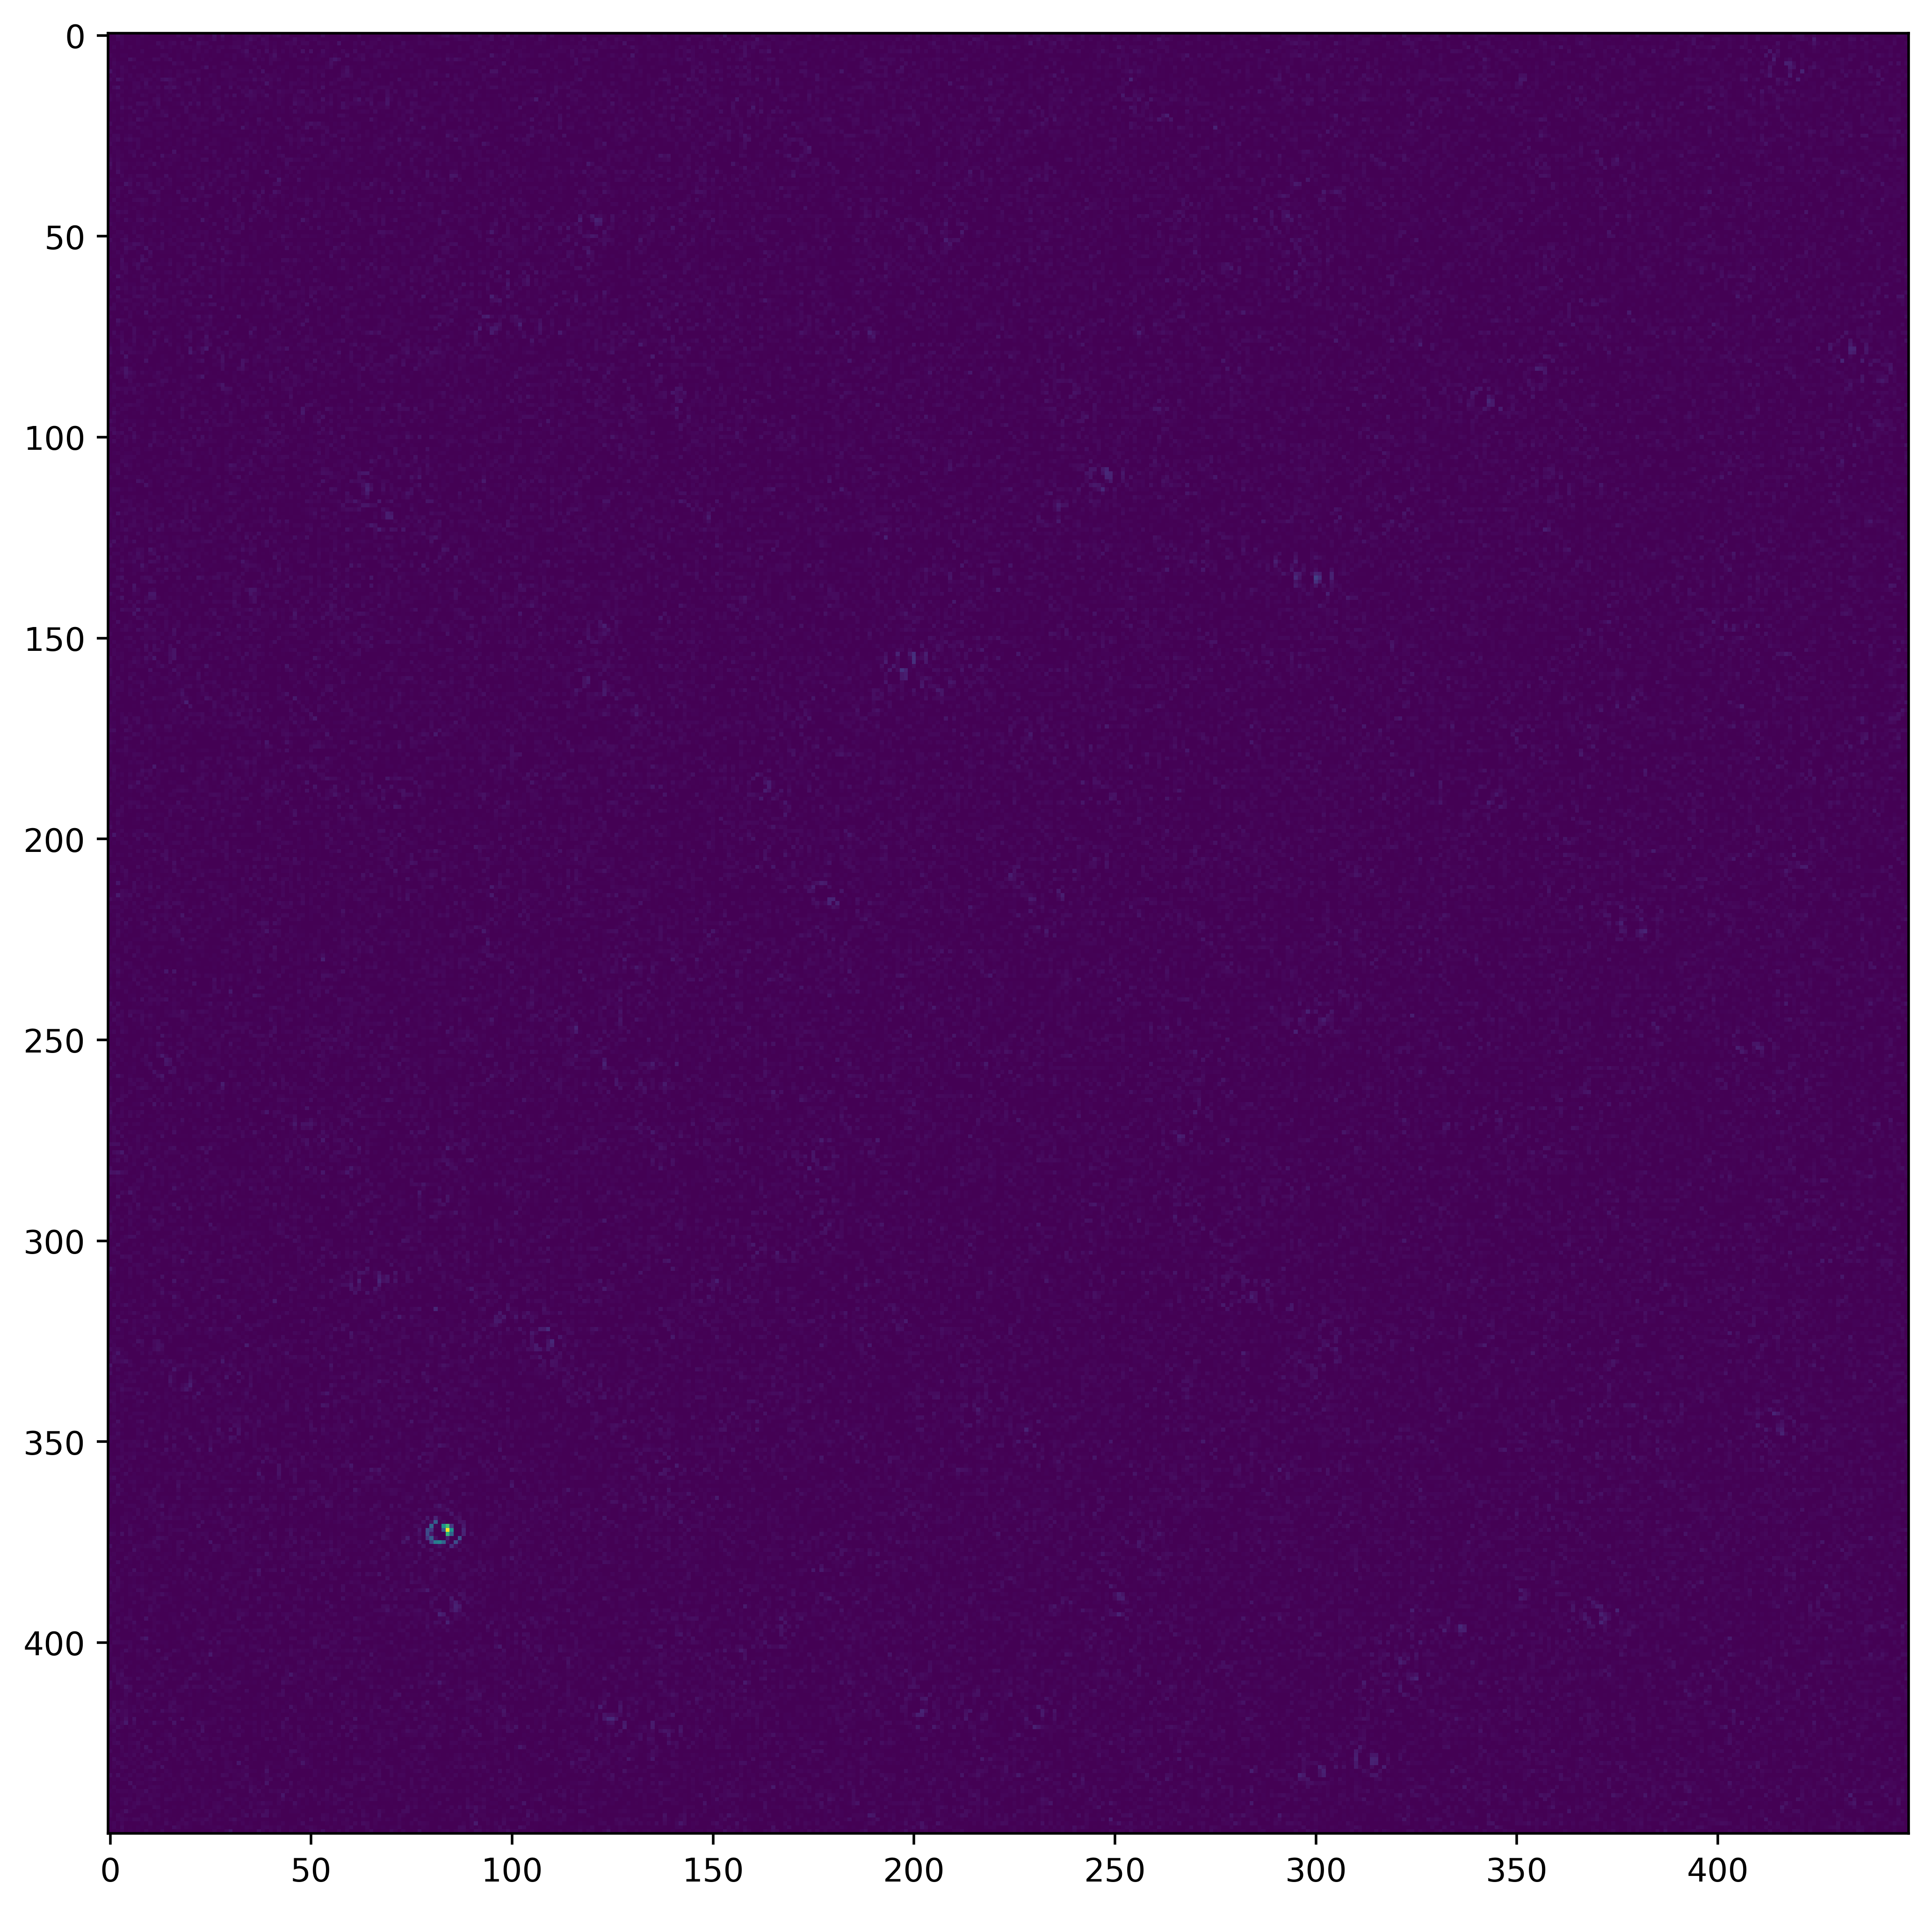

In [71]:
plt.figure(figsize=(10,10),dpi=500)
plt.imshow(images[-1])


In [30]:
for i in range(len(images)):
    images[i] = 1-images[i]
    

In [87]:
np.mean(images)

0.024174200806197765

In [262]:
np.max(images[100])

1.0

In [23]:
torch.mean(images_train[0])

tensor(0.0248)

In [114]:
from torch import nn
import torch.nn.functional as F

class Patch_model2(nn.Module):
    def __init__(self):
        super(Patch_model2, self).__init__()
        self.m0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.0,num_classes=2000,pretrained=True)
        self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

        self.fc1=nn.Linear(2000, 1000)
        self.fc2=nn.Linear(1000,500)


    def forward(self, x):
        l2=224
        x1 = x[:,:,0:l2,0:l2]
        x2 = x[:,:,0:l2,l2:]
        x3 = x[:,:,l2:,0:l2]
        x4 = x[:,:,l2:,l2:]
        #torch.cuda.empty_cache()
        #gc.collect()
        x = F.gelu(self.m0(x))
        x1 = F.gelu(self.m1(x1))
        x2 = F.gelu(self.m2(x2))
        x3 = F.gelu(self.m3(x3))
        x4 = F.gelu(self.m4(x4))
        x0 = torch.cat([x1,x2,x3,x4],dim=1)
        del x1,x2, x3, x4
        x = x*x0
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x#,x2,x3,x4

class Patch_model3(nn.Module):
    def __init__(self):
        super(Patch_model3, self).__init__()
        self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

        self.fc1=nn.Linear(2000, 1000)
        self.fc2=nn.Linear(1000,500)


    def forward(self, x):
        l2=224
        x1 = x[:,:,0:l2,0:l2]
        x2 = x[:,:,0:l2,l2:]
        x3 = x[:,:,l2:,0:l2]
        x4 = x[:,:,l2:,l2:]
        #torch.cuda.empty_cache()
        #gc.collect()
        x1 = F.gelu(self.m1(x1))
        x2 = F.gelu(self.m2(x2))
        x3 = F.gelu(self.m3(x3))
        x4 = F.gelu(self.m4(x4))
        x = torch.cat([x1,x2,x3,x4],dim=1)
        del x1,x2, x3, x4
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x#,x2,x3,x4

class Patch_model(nn.Module):
    def __init__(self):
        super(Patch_model, self).__init__()
        self.m0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.0,num_classes=2000,pretrained=True)
        self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

        self.fc1=nn.Linear(4000, 1000)
        self.fc2=nn.Linear(1000,500)


    def forward(self, x):
        l2=224
        x1 = x[:,:,0:l2,0:l2]
        x2 = x[:,:,0:l2,l2:]
        x3 = x[:,:,l2:,0:l2]
        x4 = x[:,:,l2:,l2:]
        #torch.cuda.empty_cache()
        #gc.collect()
        x = F.gelu(self.m0(x))
        x1 = F.gelu(self.m1(x1))
        x2 = F.gelu(self.m2(x2))
        x3 = F.gelu(self.m3(x3))
        x4 = F.gelu(self.m4(x4))
        x0 = torch.cat([x1,x2,x3,x4],dim=1)
        del x1,x2, x3, x4
        x = torch.cat([x,x0],dim=1)#x*x0
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x#,x2,x3,x4

class Net0(nn.Module):
    def __init__(self):
        super(Net0, self).__init__()
        self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)

        # self.fc1=nn.Linear(4000,2000)
        # self.fc2 = nn.Linear(2000,1000)

        #self.fc3=nn.Linear(1000,1000)
        # self.fc3_2=nn.Linear(10,1)
        # self.fc4=nn.Linear(4000,10)
        # self.fc4_2=nn.Linear(10,1)
        # self.fc5=nn.Linear(4000,10)
        # self.fc5_2=nn.Linear(10,1)

    def forward(self, x):
        x = self.m1(x)
        
        # x = F.gelu(self.fc1(x))
        # x = self.fc2(x)
       # x = self.fc3(x)

        # x2 = F.gelu(self.fc3(x))
        # x2 = self.fc3_2(x2)
        # x3 = F.gelu(self.fc4(x))
        # x3 = self.fc4_2(x3)
        # x4 = F.gelu(self.fc5(x))
        # x4 = self.fc5_2(x4)

        return x#,x2,x3,x4
    

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gc
from torch.optim.lr_scheduler import StepLR
import torchvision as tv
import timm
device='cuda'
# m1 = timm.create_model('regnety_016', in_chans=40, drop_path_rate=.0,num_classes=4000,pretrained=True)
# model=Net2()
# model.to(device)
# Define your custom dataset

class TestDataset2(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]

        return image.float()

In [33]:
# timm.list_models()
model

Patch_model(
  (m0): VOLO(
    (patch_embed): PatchEmbed(
      (conv): Sequential(
        (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
      )
      (proj): Conv2d(64, 256, kernel_size=(4, 4), stride=(4, 4))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (network): ModuleList(
      (0): Sequential(
        (0): Outlooker(
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=Tr

In [17]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [115]:
model6 = Patch_model3()
model6.load_state_dict(torch.load('models/speed_model_volod1_patch_4x224px_dispBrown_4_21'))
model6.to(device).eval()

model7 = Patch_model()
model7.load_state_dict(torch.load('models/speed_model_Volo224-448_dispBrown_patch_v3'))
model7.to(device).eval()

model8 =Patch_model2()
model8.load_state_dict(torch.load('models/speed_model_Volo224-448_dispBrown_patch_v1'))
model8.to(device).eval()

Patch_model2(
  (m0): VOLO(
    (patch_embed): PatchEmbed(
      (conv): Sequential(
        (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
      )
      (proj): Conv2d(64, 256, kernel_size=(4, 4), stride=(4, 4))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (network): ModuleList(
      (0): Sequential(
        (0): Outlooker(
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=T

In [112]:
model5 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=.0,num_classes=1000,pretrained=False)
model5.load_state_dict(torch.load('models/speed_model_volod3_448px_dispBrown_4_22_v2'))
model5.to(device).eval()

model1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=.0,num_classes=1000,pretrained=False)
model1.load_state_dict(torch.load('models/speed_model_volod3_448px_dispBrown_4_22'))
model1.to(device).eval()

model2 = timm.create_model('twins_svt_small', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model2.load_state_dict(torch.load('models/speed_model_TwinsSvtSmall_500px_opposite_dispBrown_4_21'))
model2.to(device).eval()

model3 = timm.create_model('volo_d2_224', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model3.load_state_dict(torch.load('models/speed_model_volod1_224px_disp_4_21'))
model3.to(device).eval()

model4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model4.load_state_dict(torch.load('models/speed_model_volod1_224px_dispBrown_4_21'))
model4.to(device).eval()

VOLO(
  (patch_embed): PatchEmbed(
    (conv): Sequential(
      (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (proj): Conv2d(64, 192, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (network): ModuleList(
    (0): Sequential(
      (0): Outlooker(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): OutlookAttention(
          (v): Linear

In [53]:
model9 = Net0()
model9.load_state_dict(torch.load('models/speed_model_Volo384_dispBrown_full'))
model9.to(device).eval()

model10 = Net0()
model10.load_state_dict(torch.load('models/speed_model_Volo384_dispBrown_fullv2'))
model10.to(device).eval()

model11 = Net0()
model11.load_state_dict(torch.load('models/speed_model_Volo384_dispBrown_fullv3'))
model11.to(device).eval()

model12 = Net0()
model12.load_state_dict(torch.load('models/speed_model_Volo384_dispBrown_full_new_v1'))
model12.to(device).eval()


Net0(
  (m1): VOLO(
    (patch_embed): PatchEmbed(
      (conv): Sequential(
        (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
      )
      (proj): Conv2d(64, 192, kernel_size=(4, 4), stride=(4, 4))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (network): ModuleList(
      (0): Sequential(
        (0): Outlooker(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
   

In [89]:
#Paen
#images = images[22:,:,:].reshape([(images.shape[0]-22)//40,40,500,500])
#Geo
#images = images[:-39,:,:].reshape([(images.shape[0]-39)//40,40,500,500])
images = images.reshape([(images.shape[0])//40,40,448,448])
images.shape

(80, 40, 448, 448)

In [233]:
images.shape

(40, 40, 500, 500)

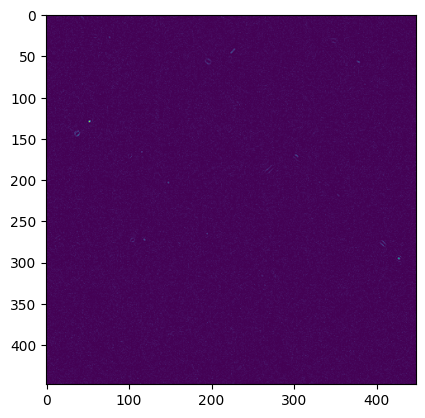

In [90]:
images = torch.tensor(images)
dataset_test = TestDataset2(images)#  xtorch_test, distr_torch_test, scales_test2)
batch_size = 10
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0)
x = next(iter(test_dataloader))
plt.imshow(x[0,39,:,:])

In [67]:
model1

VOLO(
  (patch_embed): PatchEmbed(
    (conv): Sequential(
      (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (proj): Conv2d(64, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (network): ModuleList(
    (0): Sequential(
      (0): Outlooker(
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): OutlookAttention(
          (v): Linear

In [269]:
import torchvision
outputs=[]
outputs2=[]
model1.eval()
model2.eval()
model11.eval()
model10.eval()
model9.eval()
model8.eval()
model7.eval()
model6.eval()
with torch.no_grad():
    for x in test_dataloader:
        x=1-x
        x1 = torchvision.transforms.functional.resize(x, 448)
        #x2 = torchvision.transforms.functional.resize(x, 224)
        x3 = torchvision.transforms.functional.resize(x, 384)
        out1_1000 = (model1((1-x1).to(device)).detach().cpu().numpy())
        out1 = np.zeros([batch_size,500])
        for i in range(len(out1)):
            out1[i,:] = interpolate_vectors(out1_1000[i,:],500)
        out2 = (model2((x).to(device)).detach().cpu().numpy())
        out11 = (model11((x3).to(device)).detach().cpu().numpy())
        out10 =(model10((x3).to(device)).detach().cpu().numpy())
        out9 = (model9((x3).to(device)).detach().cpu().numpy())
        out8 = (model8((x1).to(device)).detach().cpu().numpy())
        out7 =(model7((x1).to(device)).detach().cpu().numpy())
        out6 = (model6((1-x1).to(device)).detach().cpu().numpy())
        #1ulh
        #out=(out1*18+out6*2+out9*1.5+out11*1+out10*1.5+out7*6+out2*2)/32
        out=(out1*10+out6*2+out9*50+out11*2+out10*2+out7*4+out2*10)/80

        #5ulh
        #out=(out6*4+out2*1+out9*.5+out11*1+out10*2.5)/9

        outputs.append(out)
        #outputs2.append(out2)

In [91]:
model.eval()
# model9.eval()
# # model10.eval()
# model11.eval()
import torchvision
outputs=[]

with torch.no_grad():
    for x in test_dataloader:
        #x1 = torchvision.transforms.functional.resize(x, 384)
        # out1_1000 = np.sort(model((x).to(device)).detach().cpu().numpy())
        # out1 = np.zeros([batch_size,500])
        # for i in range(len(out1)):
        #     out1[i,:] = interpolate_vectors(out1_1000[i,:],500)
        #out2 = np.sort(model9((1-x1).to(device)).detach().cpu().numpy())
        #out11 = (model11((x1).to(device)).detach().cpu().numpy())
        out10 =(model((x).to(device)).detach().cpu().numpy())
        #out = (out11*3+out10*1+out2*2)/6

        outputs.append(out10)

In [62]:
np.mean(out11)
#np.max(out9)


2.1948204

In [92]:
np.mean(outputs)


9.056802

In [142]:
(9.2+10.44+15.41+18.37+19.03+9.3+11.1)/7

13.264285714285714

In [130]:
#model7 = 9.2
#model8 = 10.44
#model9 = 15.41
#model10 = 18.37
#model11 = 19.03
#model1 = 9.3
#model2 = 11.1
#model5 = 8.9
#model4 = 7.89
#looking for 13.5
np.mean(out0)


2.0464344

In [94]:
out = np.reshape(np.hstack(outputs),[40000 ,])
out = out[out>0]
out.shape

(39978,)

In [95]:
np.mean(out)
#np.sort(out)

9.061822

### Geobacter 1 = "out"

In [96]:
def interpolate_vectors(vector, target_length):
    current_length = len(vector)
    # Create a new x-axis with the desired length
    new_x = np.linspace(0, current_length - 1, target_length)
    # Create the old x-axis based on the current length
    old_x = np.arange(current_length)
    # Perform linear interpolation
    interpolated_vector = np.interp(new_x, old_x, vector)
    return interpolated_vector

In [97]:
directory='../tmate_trajectories/'
filename = os.listdir(directory)[4]
print(filename)
df = pd.read_csv(os.path.join(directory,filename),header=0, skiprows=[1,2,3])
#df.Positio
tracks = df.TRACK_ID.unique()
vels=1
for i in range(len(tracks)):
    idx = tracks[i]
    posx = .325*df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_X
    posy = .325*df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_Y
    
    posx[posx==0]=np.nan
    posy[posy==0]=np.nan
    vel = (np.sqrt(posx.diff()**2+posy.diff()**2)/.12).dropna()

    vels = np.hstack([vels, vel])

geo_5ulh_001.csv


In [98]:
vels = vels[vels<1600]
vels = vels[vels>0]

In [45]:
13.5*.325/.12

36.5625

In [36]:
#np.sort(out)
outputs

[array([[8.85408  ],
        [8.385267 ],
        [6.8508973],
        [5.6555185],
        [6.0535483],
        [5.8594112],
        [4.9850802],
        [6.492897 ],
        [4.309014 ],
        [5.54431  ]], dtype=float32),
 array([[6.5114355],
        [5.108121 ],
        [5.874606 ],
        [5.351591 ],
        [6.576599 ],
        [5.389121 ],
        [8.127933 ],
        [2.6333199],
        [2.6572692],
        [2.3701496]], dtype=float32),
 array([[2.395002 ],
        [2.8745584],
        [3.7165349],
        [6.216325 ],
        [3.5018196],
        [6.5842123],
        [4.2190976],
        [5.2389545],
        [5.3549385],
        [8.125989 ]], dtype=float32),
 array([[ 7.201876 ],
        [ 7.1068473],
        [ 8.694857 ],
        [10.67993  ],
        [ 8.523431 ],
        [ 8.576146 ],
        [ 1.7150718],
        [ 1.5246905],
        [ 1.8286624],
        [ 1.801776 ]], dtype=float32)]

In [99]:
print(np.mean(out*.325/.12))
print(np.mean(vels))

24.542433
36.22973597756184


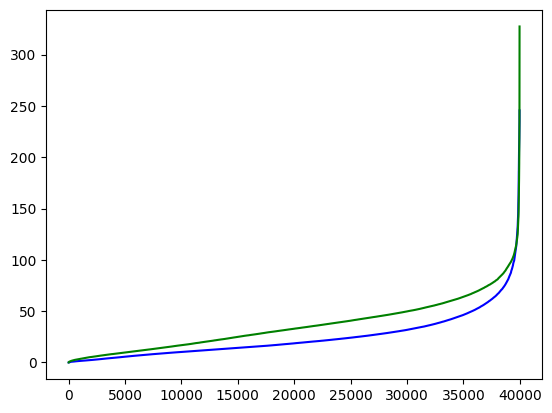

In [100]:
vels = interpolate_vectors(np.sort(vels), len(out))
plt.plot(np.sort(out*.325/.12), c='b')
plt.plot(np.sort(vels), c='g')

In [194]:
out9

array([[ 0.22209093,  0.25038034,  0.34893346, ..., 11.34177   ,
        11.70568   , 11.738928  ],
       [ 0.2968163 ,  0.48029998,  0.6837623 , ..., 17.711487  ,
        18.333992  , 18.795027  ],
       [ 0.21306908,  0.31568995,  0.48046038, ..., 12.694013  ,
        12.727563  , 13.219395  ],
       ...,
       [ 0.80567646,  1.044989  ,  1.5838839 , ..., 28.494247  ,
        28.544308  , 29.16348   ],
       [ 0.09980573,  0.31273535,  0.4661638 , ..., 12.468898  ,
        12.978033  , 14.832543  ],
       [ 0.2026592 ,  0.35081166,  0.49359772, ..., 13.917014  ,
        14.443405  , 15.057994  ]], dtype=float32)

(4e-05, 0.1)

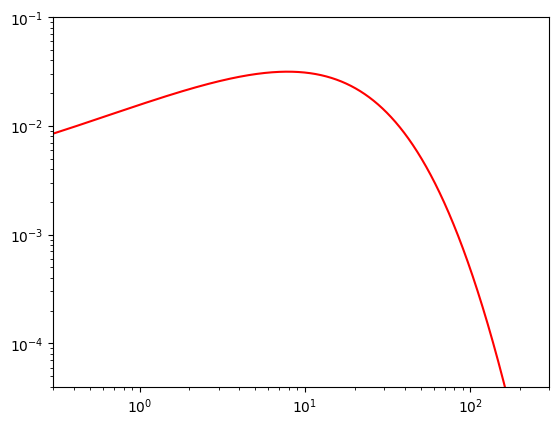

In [101]:
from scipy.stats import exponweib,lognorm, beta, betaprime, norm
#new_out=(out6*4+out2*1+out9*.5+out11*1+out10*2.5)/9
a,b,c,d= betaprime.fit(np.sort(out*.325/.12))
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), 4000)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='r')
plt.xscale('log')
plt.yscale('log')
plt.xlim([3e-1,3e2])
plt.ylim([4e-5,.1])

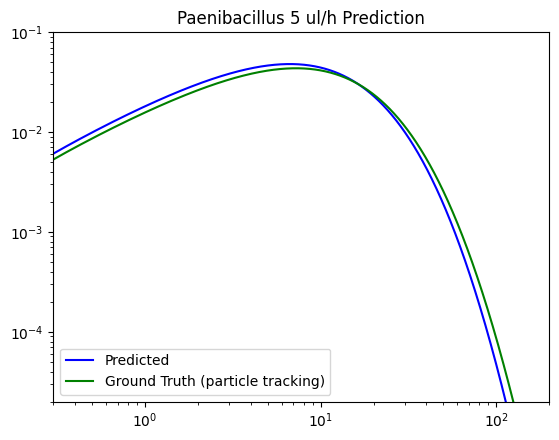

In [294]:
from scipy.stats import exponweib,lognorm, beta, betaprime, norm

a,b,c,d= betaprime.fit(np.sort(vels))
xvel= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), 4000)
distr_vel=betaprime.pdf(xvel, a,b,c,d)
plt.plot(xtorch,distr_torch,c='b')
plt.plot(xvel,distr_vel,c='g')
plt.xscale('log')
plt.yscale('log')
plt.xlim([3e-1,2e2])
plt.ylim([2e-5,.1])
plt.title('Paenibacillus 5 ul/h Prediction')
plt.legend(['Predicted', 'Ground Truth (particle tracking)'])

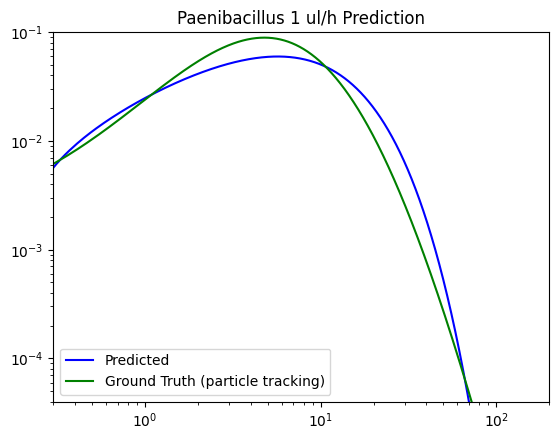

In [252]:
from scipy.stats import exponweib,lognorm, beta, betaprime, norm

a,b,c,d= betaprime.fit(np.sort(vels))
xvel= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), 4000)
distr_vel=betaprime.pdf(xvel, a,b,c,d)
plt.plot(xtorch,distr_torch,c='b')
plt.plot(xvel,distr_vel,c='g')
plt.xscale('log')
plt.yscale('log')
plt.xlim([3e-1,2e2])
plt.ylim([4e-5,.1])
plt.title('Paenibacillus 1 ul/h Prediction')
plt.legend(['Predicted', 'Ground Truth (particle tracking)'])

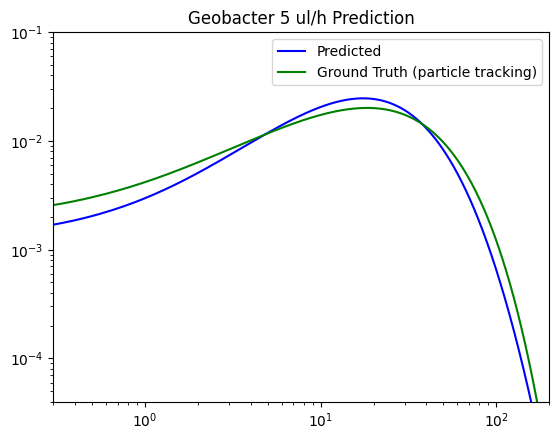

In [350]:
from scipy.stats import exponweib,lognorm, beta, betaprime, norm

a,b,c,d= betaprime.fit(np.sort(vels))
xvel= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), 4000)
distr_vel=betaprime.pdf(xvel, a,b,c,d)
plt.plot(xtorch,distr_torch,c='b')
plt.plot(xvel,distr_vel,c='g')
plt.xscale('log')
plt.yscale('log')
plt.xlim([3e-1,2e2])
plt.ylim([4e-5,.1])
plt.title('Geobacter 5 ul/h Prediction')
plt.legend(['Predicted', 'Ground Truth (particle tracking)'])

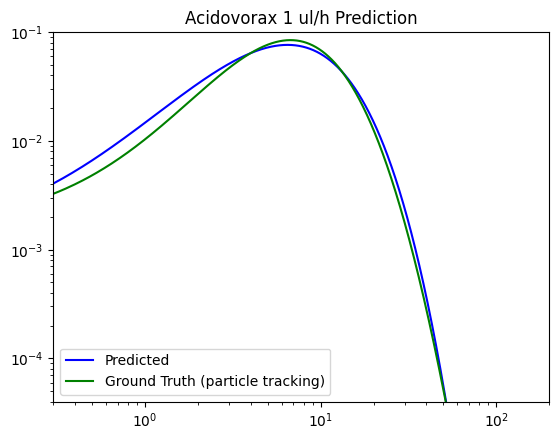

In [113]:
from scipy.stats import exponweib,lognorm, beta, betaprime, norm

a,b,c,d= betaprime.fit(np.sort(vels))
xvel= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), 4000)
distr_vel=betaprime.pdf(xvel, a,b,c,d)
plt.plot(xtorch,distr_torch,c='b')
plt.plot(xvel,distr_vel,c='g')
plt.xscale('log')
plt.yscale('log')
plt.xlim([3e-1,2e2])
plt.ylim([4e-5,.1])
plt.title('Acidovorax 1 ul/h Prediction')
plt.legend(['Predicted', 'Ground Truth (particle tracking)'])

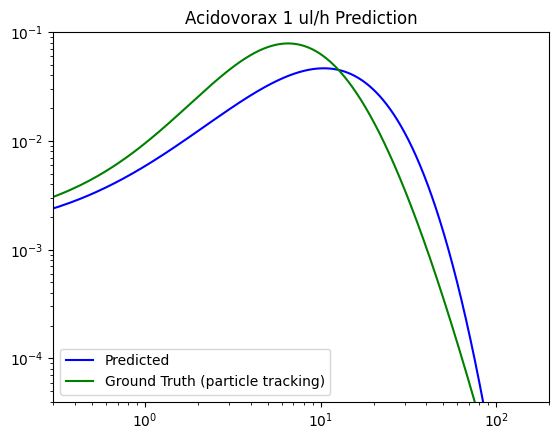

In [344]:
from scipy.stats import exponweib,lognorm, beta, betaprime, norm

a,b,c,d= betaprime.fit(np.sort(vels))
xvel= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), 4000)
distr_vel=betaprime.pdf(xvel, a,b,c,d)
plt.plot(xtorch,distr_torch,c='b')
plt.plot(xvel,distr_vel,c='g')
plt.xscale('log')
plt.yscale('log')
plt.xlim([3e-1,2e2])
plt.ylim([4e-5,.1])
plt.title('Acidovorax 1 ul/h Prediction')
plt.legend(['Predicted', 'Ground Truth (particle tracking)'])

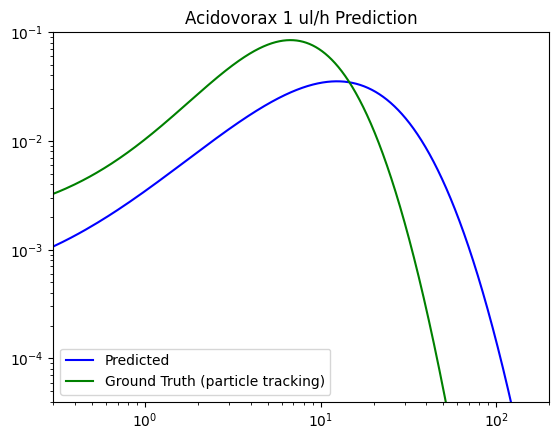

In [274]:
from scipy.stats import exponweib,lognorm, beta, betaprime, norm

a,b,c,d= betaprime.fit(np.sort(vels))
xvel= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), 4000)
distr_vel=betaprime.pdf(xvel, a,b,c,d)
plt.plot(xtorch,distr_torch,c='b')
plt.plot(xvel,distr_vel,c='g')
plt.xscale('log')
plt.yscale('log')
plt.xlim([3e-1,2e2])
plt.ylim([4e-5,.1])
plt.title('Acidovorax 1 ul/h Prediction')
plt.legend(['Predicted', 'Ground Truth (particle tracking)'])

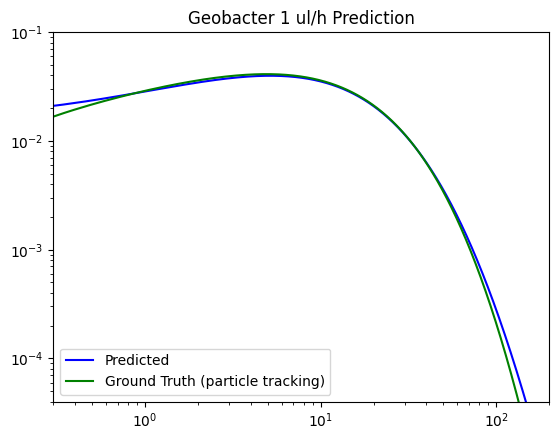

In [51]:
from scipy.stats import exponweib,lognorm, beta, betaprime, norm

a,b,c,d= betaprime.fit(np.sort(vels))
xvel= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), 4000)
distr_vel=betaprime.pdf(xvel, a,b,c,d)
plt.plot(xtorch,distr_torch,c='b')
plt.plot(xvel,distr_vel,c='g')
plt.xscale('log')
plt.yscale('log')
plt.xlim([3e-1,2e2])
plt.ylim([4e-5,.1])
plt.title('Geobacter 1 ul/h Prediction')
plt.legend(['Predicted', 'Ground Truth (particle tracking)'])

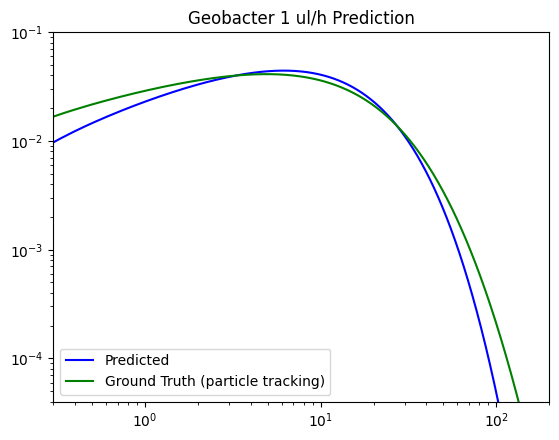

In [213]:
from scipy.stats import exponweib,lognorm, beta, betaprime, norm

a,b,c,d= betaprime.fit(np.sort(vels))
xvel= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), 4000)
distr_vel=betaprime.pdf(xvel, a,b,c,d)
plt.plot(xtorch,distr_torch,c='b')
plt.plot(xvel,distr_vel,c='g')
plt.xscale('log')
plt.yscale('log')
plt.xlim([3e-1,2e2])
plt.ylim([4e-5,.1])
plt.title('Geobacter 1 ul/h Prediction')
plt.legend(['Predicted', 'Ground Truth (particle tracking)'])

# Model Training

In [1]:
import os

sim_dir = os.listdir('all_sims')
file_dir = os.listdir('all_traj_files')
# Custom sorting key function
def sort_key(item):
    if '_brown' in item:
        return (1, int(item[3:-6]))
    elif 'straight' in item:
        return (2, int(item[3:-9]))
    elif 'blank' in item:
        return (3, int(item[3:-6]))
    else:
        return (0, int(item[3:]))

# Sort the list using the custom key
sorted_sim_dir = sorted(sim_dir, key=sort_key)
#sorted_sim_dir=sorted_sim_dir[0:200]
print(sorted_sim_dir)

['sim61', 'sim62', 'sim63', 'sim64', 'sim65', 'sim66', 'sim67', 'sim68', 'sim69', 'sim70', 'sim71', 'sim72', 'sim73', 'sim74', 'sim75', 'sim76', 'sim77', 'sim78', 'sim79', 'sim80', 'sim81', 'sim82', 'sim83', 'sim84', 'sim85', 'sim86', 'sim87', 'sim88', 'sim89', 'sim90', 'sim91', 'sim92', 'sim93', 'sim94', 'sim95', 'sim96', 'sim97', 'sim98', 'sim99', 'sim100', 'sim101', 'sim102', 'sim103', 'sim104', 'sim105', 'sim106', 'sim107', 'sim108', 'sim109', 'sim110', 'sim111', 'sim112', 'sim113', 'sim114', 'sim115', 'sim116', 'sim117', 'sim118', 'sim119', 'sim120', 'sim121', 'sim122', 'sim123', 'sim124', 'sim125', 'sim126', 'sim127', 'sim128', 'sim129', 'sim130', 'sim131', 'sim132', 'sim133', 'sim134', 'sim135', 'sim136', 'sim137', 'sim138', 'sim139', 'sim140', 'sim141', 'sim142', 'sim143', 'sim144', 'sim145', 'sim146', 'sim147', 'sim148', 'sim149', 'sim150', 'sim151', 'sim152', 'sim153', 'sim154', 'sim155', 'sim156', 'sim157', 'sim158', 'sim159', 'sim161', 'sim162', 'sim163', 'sim164', 'sim165'

In [2]:
sim_dir[20][3:-9]
895*2

1790

In [3]:
import os


# Custom sorting key function
def sort_key2(item):
    if '_brown' in item:
        return (1, int(item[6:-10]))
    elif 'straight' in item:
        return (2, int(item[6:-13]))
    elif 'blank' in item:
        return (3, int(item[6:-10])) # Extract the numeric part for files with '_brown'
    else:
        return (0, int(item[6:-4]))  # Extract the numeric part for files without '_brown'

# Sort the list using the custom key
sorted_file_dir = sorted(file_dir, key=sort_key2)

# Split the sorted list into 'yc_' and 'xc_' files
yc_files = [f for f in sorted_file_dir if f.startswith('yc_')]
xc_files = [f for f in sorted_file_dir if f.startswith('xc_')]

# Create a list of lists with corresponding 'yc_' and 'xc_' files
sorted_file_pairs = [[yc, xc] for yc, xc in zip(yc_files, xc_files)]

#sorted_file_pairs=sorted_file_pairs[0:200]
print(sorted_file_pairs)

[['yc_sim61.csv', 'xc_sim61.csv'], ['yc_sim62.csv', 'xc_sim62.csv'], ['yc_sim63.csv', 'xc_sim63.csv'], ['yc_sim64.csv', 'xc_sim64.csv'], ['yc_sim65.csv', 'xc_sim65.csv'], ['yc_sim66.csv', 'xc_sim66.csv'], ['yc_sim67.csv', 'xc_sim67.csv'], ['yc_sim68.csv', 'xc_sim68.csv'], ['yc_sim69.csv', 'xc_sim69.csv'], ['yc_sim70.csv', 'xc_sim70.csv'], ['yc_sim71.csv', 'xc_sim71.csv'], ['yc_sim72.csv', 'xc_sim72.csv'], ['yc_sim73.csv', 'xc_sim73.csv'], ['yc_sim74.csv', 'xc_sim74.csv'], ['yc_sim75.csv', 'xc_sim75.csv'], ['yc_sim76.csv', 'xc_sim76.csv'], ['yc_sim77.csv', 'xc_sim77.csv'], ['yc_sim78.csv', 'xc_sim78.csv'], ['yc_sim79.csv', 'xc_sim79.csv'], ['yc_sim80.csv', 'xc_sim80.csv'], ['yc_sim81.csv', 'xc_sim81.csv'], ['yc_sim82.csv', 'xc_sim82.csv'], ['yc_sim83.csv', 'xc_sim83.csv'], ['yc_sim84.csv', 'xc_sim84.csv'], ['yc_sim85.csv', 'xc_sim85.csv'], ['yc_sim86.csv', 'xc_sim86.csv'], ['yc_sim87.csv', 'xc_sim87.csv'], ['yc_sim88.csv', 'xc_sim88.csv'], ['yc_sim89.csv', 'xc_sim89.csv'], ['yc_sim90.cs

In [4]:
# from sklearn.model_selection import train_test_split

# # Create a range of numbers from 0 to 534
# indices = range(535)

# # Perform the train-test split
# train_indices, test_indices = train_test_split(indices, test_size=0.2)

In [5]:
# test_indices

In [6]:
# test_dirs = [sorted_file_pairs[i] for i in test_indices]
# train_dirs = [sorted_file_pairs[i] for i in train_indices]

# len(test_dirs)

In [7]:
train_dirs = sorted_file_pairs#[0:-100]+sorted_file_pairs[5::6]
train_dirs = sorted_file_pairs[1::5]+sorted_file_pairs[2::5]+sorted_file_pairs[3::5]+sorted_file_pairs[4::5]#+sorted_file_pairs[7::7]
len(train_dirs)
test_dirs = sorted_file_pairs[0::5]

In [8]:
# test_image_files = [sorted_sim_dir[i] for i in test_indices]
# train_image_files = [sorted_sim_dir[i] for i in train_indices]

In [9]:
train_image_files = sorted_sim_dir[1::5]+sorted_sim_dir[2::5]+sorted_sim_dir[3::5]+sorted_sim_dir[4::5]#+sorted_file_pairs[7::7]
print(len(train_dirs))
test_image_files = sorted_sim_dir[0::5]


556


In [10]:
# train_image_files = sorted_sim_dir#[0:-100]
# train_image_files = sorted_sim_dir[1::6]+sorted_sim_dir[2::6]+sorted_sim_dir[3::6]+sorted_sim_dir[4::6]+sorted_sim_dir[5::6]#+sorted_file_pairs[6::7]+sorted_file_pairs[7::7]
# len(train_dirs)
# #train_image_files = sorted_sim_dir[1::7]+sorted_sim_dir[2::7]+sorted_sim_dir[3::7]+sorted_sim_dir[4::7]+sorted_sim_dir[5::7]+sorted_sim_dir[6::7]+sorted_sim_dir[7::7]

len(train_image_files)

556

In [11]:
len(test_image_files)

139

In [12]:
len(test_dirs)

139

In [13]:
import timm

In [14]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [10]:
swinv2_small_window16_256
vit_so150m_patch16_reg4_gap_256
maxxvitv2_nano_rw_256
levit_conv_256d

768

In [13]:
import pandas as pd
import numpy as np
import cv2
import os
import torch
import re
#torch.set_default_dtype(torch.float16)

# import joblib
# import os
# import cv2
# import torch
# import re
# import numpy as np

# s = 384
# k = 40
# train_image_files = [...]  # your list of train image files
# test_image_files = [...]  # your list of test image files

# def process_image(file):
#     base = 'all_sims/' + file
#     im_dir = os.listdir(base)
#     im_dir = sorted(im_dir, key=lambda x: int(re.findall(r'\d+', x)[0]))
#     images = []
#     for j in range(k):
#         img = cv2.resize(cv2.imread(base + '/' + im_dir[j], cv2.IMREAD_GRAYSCALE), (s, s))
#         img = (img - np.min(img)) / (np.max(img) - np.min(img))
#         images.append(img)
#     return images

# images_train = joblib.Parallel(n_jobs=8)(joblib.delayed(process_image)(file) for file in train_image_files)
# images_test = joblib.Parallel(n_jobs=8)(joblib.delayed(process_image)(file) for file in test_image_files)

# # Convert the list of tensors to a tensor
# images_train = torch.stack(torch.tensor(images_train))
# images_test = torch.stack(torch.tensor(images_test))

# # Convert the list of tensors to a tensor
# images_train = torch.stack(images_train)
# images_test = torch.stack(images_test)

# train_image_files=['../500part_4xspeed_heterogeneous/','../2000part_4xspeed_heterogeneous/', '../2000part_16xspeed_heterogeneous/',
#                   '../2000part_32xspeed_heterogeneous/','../1000part_16xspeed_heterogeneous/','../500part_32xspeed_heterogeneous/',
#                   '../1000part_32xspeed_heterogeneous/', 'sim2/', 'sim11/', 'sim12/', 'sim13/', 'sim14/', 'sim19/','sim20/','sim21/',
#                    'sim22/','sim23/','sim24/','sim25/','sim35/','sim36/','sim46/','sim62/','sim63/','sim64/','sim65/','sim66/',
#                   'sim67/','sim16/']
# train_image_files=['sim62/','sim63/','sim64/','sim66/',
#                   'sim67/','sim68/','sim69/', 'sim72/','sim73/','sim74/','sim76/',
#                   'sim77/','sim78/','sim79/', 'sim82/','sim83/','sim84/','sim86/',
#                   'sim87/','sim88/','sim89/', 'sim92/','sim93/','sim94/','sim96/',
#                   'sim97/','sim98/','sim99/', 'sim102/','sim103/','sim104/','sim106/',
#                   'sim107/','sim108/','sim109/', 'sim112/','sim113/','sim114/','sim116/',
#                   'sim117/','sim118/','sim119/', 'sim122/','sim123/','sim124/','sim116/',
#                   'sim117/','sim118/','sim119/', 'sim132/','sim133/','sim134/','sim116/',
#                   'sim117/','sim118/','sim119/', 'sim142/','sim143/','sim144/','sim116/',
#                   'sim117/','sim118/','sim119/', 'sim112/','sim113/','sim114/','sim116/',
#                   'sim117/','sim118/','sim119/', 'sim112/','sim113/','sim114/','sim116/',
#                   'sim117/','sim118/','sim119/']
# test_image_files=['sim61/','sim65/','sim70/','sim71/','sim75/','sim80/','sim81/','sim85/','sim90/',
#                   'sim91/','sim95/','sim100/','sim101/','sim105/','sim110/','sim111/','sim115/','sim120/']
s=448
k=40
images_train = torch.zeros(len(train_image_files),k,s, s)
images_test = torch.zeros(len(test_image_files),k,s, s)
for i in range(len(train_image_files)):
    base = 'all_sims/'+train_image_files[i]
    im_dir = os.listdir(base)
    im_dir = sorted(im_dir, key=lambda x: int(re.findall(r'\d+', x)[0]))
    for j in range(k):
        
        img= torch.tensor(cv2.resize(cv2.imread(base+'/'+im_dir[j], cv2.IMREAD_GRAYSCALE),(s,s)))
        img = (img-torch.min(img))/(torch.max(img)-torch.min(img))
        images_train[i,j,:,:] = img


for i in range(len(test_image_files)):
    base = 'all_sims/'+test_image_files[i]
    im_dir = os.listdir(base)
    im_dir = sorted(im_dir, key=lambda x: int(re.findall(r'\d+', x)[0]))
    for j in range(k):
        
        img = torch.tensor(cv2.resize(cv2.imread(base+'/'+im_dir[j], cv2.IMREAD_GRAYSCALE),(s,s)))
        img = (img-torch.min(img))/(torch.max(img)-torch.min(img))
        images_test[i,j,:,:] = img
        
im_dir

['Fig_1.jpg',
 'Fig_2.jpg',
 'Fig_3.jpg',
 'Fig_4.jpg',
 'Fig_5.jpg',
 'Fig_6.jpg',
 'Fig_7.jpg',
 'Fig_8.jpg',
 'Fig_9.jpg',
 'Fig_10.jpg',
 'Fig_11.jpg',
 'Fig_12.jpg',
 'Fig_13.jpg',
 'Fig_14.jpg',
 'Fig_15.jpg',
 'Fig_16.jpg',
 'Fig_17.jpg',
 'Fig_18.jpg',
 'Fig_19.jpg',
 'Fig_20.jpg',
 'Fig_21.jpg',
 'Fig_22.jpg',
 'Fig_23.jpg',
 'Fig_24.jpg',
 'Fig_25.jpg',
 'Fig_26.jpg',
 'Fig_27.jpg',
 'Fig_28.jpg',
 'Fig_29.jpg',
 'Fig_30.jpg',
 'Fig_31.jpg',
 'Fig_32.jpg',
 'Fig_33.jpg',
 'Fig_34.jpg',
 'Fig_35.jpg',
 'Fig_36.jpg',
 'Fig_37.jpg',
 'Fig_38.jpg',
 'Fig_39.jpg',
 'Fig_40.jpg']

In [14]:
import matplotlib.pyplot as plt
#plt.imshow(images_train[100,30,:,:])
images_train.shape

torch.Size([556, 40, 448, 448])

In [45]:
import gc
del im_dir
gc.collect()

NameError: name 'im_dir' is not defined

In [15]:
import pandas as pd
import numpy as np
import cv2
import os
import torch
import re
import matplotlib.pyplot as plt
from scipy.stats import exponweib,lognorm

def interpolate_vectors(vector, target_length):
    current_length = len(vector)
    # Create a new x-axis with the desired length
    new_x = np.linspace(0, current_length - 1, target_length)
    # Create the old x-axis based on the current length
    old_x = np.arange(current_length)
    # Perform linear interpolation
    interpolated_vector = np.interp(new_x, old_x, vector)
    return interpolated_vector
    

base='all_traj_files/'
target_length=500
speeds = torch.zeros(len(train_dirs),target_length)
for i in range(len(train_dirs)):
    x_arr= np.array(pd.read_csv(base+train_dirs[i][1], header=None))
    y_arr= np.array(pd.read_csv(base+train_dirs[i][0], header=None))
    vx = np.diff(x_arr, axis=0)
    vy = np.diff(y_arr, axis=0)
    speed = np.sqrt(vx**2+vy**2)
    speed = np.reshape(speed, [-1])
    speed=speed[~np.isnan(speed)]
    speed = speed[speed>0]
    #speed[speed<=0]=0.0001
    speed = interpolate_vectors(np.sort(speed), target_length)
    speeds[i,:] = torch.tensor(speed)


In [8]:
speeds

tensor([[2.7144e-02, 3.0194e-01, 4.1168e-01,  ..., 1.0537e+02, 1.1465e+02,
         1.6686e+02],
        [7.3393e-02, 2.6001e-01, 3.8026e-01,  ..., 4.0262e+01, 4.4238e+01,
         5.6582e+01],
        [1.0004e-01, 2.1359e-01, 3.6561e-01,  ..., 2.3675e+01, 2.7716e+01,
         3.2391e+01],
        ...,
        [3.7258e-02, 6.5837e-02, 8.0923e-02,  ..., 2.5729e+00, 2.8166e+00,
         2.9641e+00],
        [5.0806e-02, 3.7106e-01, 4.8834e-01,  ..., 1.8123e+01, 1.9068e+01,
         2.5106e+01],
        [2.7900e-02, 1.4001e-01, 1.7379e-01,  ..., 7.1535e+00, 7.5889e+00,
         9.4078e+00]])

In [16]:
# xtorch_test = torch.zeros(len(test_dirs),1000)
# distr_torch_test = torch.zeros(len(test_dirs),1000)

# test_dirs=[["xc_1000part_4xspeed.csv","yc_1000part_4xspeed.csv"],["xc_500part_16xspeed.csv","yc_500part_16xspeed.csv"],
#           ['yc_sim17.csv','xc_sim17.csv'],['yc_sim18.csv','xc_sim18.csv'], ['yc_sim40.csv','xc_sim40.csv'], ['yc_sim41.csv','xc_sim41.csv'], 
#            ['yc_sim42.csv','xc_sim42.csv'], ['yc_sim43.csv','xc_sim43.csv'], ['yc_sim44.csv','xc_sim44.csv'], ['yc_sim45.csv','xc_sim45.csv'],
#            ['yc_sim69.csv','xc_sim69.csv'],['yc_sim70.csv','xc_sim70.csv'],
# ]
# test_dirs=[ ['yc_sim61.csv','xc_sim61.csv'], ['yc_sim65.csv','xc_sim65.csv'],['yc_sim70.csv','xc_sim70.csv'],
#            ['yc_sim71.csv','xc_sim71.csv'], ['yc_sim75.csv','xc_sim75.csv'],['yc_sim80.csv','xc_sim80.csv'],
#            ['yc_sim81.csv','xc_sim81.csv'], ['yc_sim85.csv','xc_sim85.csv'],['yc_sim90.csv','xc_sim90.csv'],
# ]
# scales_test = torch.zeros(len(test_dirs),3)
# target_length=1000
speeds_test = torch.zeros(len(test_dirs),target_length)
for i in range(len(test_dirs)):
    x_arr= np.array(pd.read_csv(base+test_dirs[i][1], header=None))
    y_arr= np.array(pd.read_csv(base+test_dirs[i][0], header=None))
    vx = np.diff(x_arr, axis=0)
    vy = np.diff(y_arr, axis=0)
    speed = np.sqrt(vx**2+vy**2)
    speed = np.reshape(speed, [-1])
    speed=speed[~np.isnan(speed)]
    speed = speed[speed>0]
    #speed[speed<=0]=0.0001
    speed = interpolate_vectors(np.sort(speed), target_length)
    speeds_test[i,:] = torch.tensor(speed)


In [1]:
import timm
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [3]:
m1 = timm.create_model('volo_d3_224', in_chans=40, drop_path_rate=0.6,num_classes=512,pretrained=True)
m1

VOLO(
  (patch_embed): PatchEmbed(
    (conv): Sequential(
      (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (proj): Conv2d(64, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (network): ModuleList(
    (0): Sequential(
      (0): Outlooker(
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): OutlookAttention(
          (v): Linear

In [21]:
from torch import nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        l=200
        self.fc2=nn.Conv2d(100, l, 1, stride=2)
        #self.m1 = nn.BatchNorm1d(1000)
        self.d1 = nn.Dropout(.2)
        self.fc1=nn.Conv2d(40, 100, 1, stride=2)
        #self.m2 = nn.BatchNorm1d(l)
        self.d2 = nn.Dropout(.2)
       # self.fc2 = nn.Linear(800,l)
       # self.fc3=nn.Linear(2000,800)
       # self.fc4 = nn.Linear(800,l)
        self.fc5 = nn.Conv2d(l, 5,1, stride=1)
        #self.m3 = nn.BatchNorm1d(100)
        self.fc6 = nn.Linear(312500,1000)
        self.d3 = nn.Dropout(.2)
        self.fc7 = nn.Linear(100,4)
        self.fc8 = nn.Linear(2000,1000)

    def forward(self, x):
        b = x.shape[0]
        x = x.squeeze()
        
        l=200
        x = F.relu(self.fc1(x))
        #x = self.m1(x)
        x = self.d1(x)
        x = F.relu(self.fc2(x))
        #x = self.m2(x)
        x = self.d2(x)
        #x = x.permute(0,2,1)
        #x = F.relu(self.fc3(x))
        #x = F.relu(self.fc4(x))
        
        #x = x.view(b,l*666)
        x = F.relu(self.fc5(x))
        #x = self.m3(x)
        x = x.reshape(b, -1)
        #x = F.relu(self.fc4(x))
        x = (self.fc6(x))
        # x = self.d3(x)
        # #x = torch.flatten(x)
        # x = (self.fc8(x))
        # x = x.reshape(2,200)
        #x = self.fc7(x)
        #output = nn.functional.log_softmax(x, dim=1)
        return x

import torchvision

class Patch_model(nn.Module):
    def __init__(self):
        super(Patch_model, self).__init__()
        self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.3,num_classes=500,pretrained=True)
        self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.3,num_classes=500,pretrained=True)
        self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.3,num_classes=500,pretrained=True)
        self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.3,num_classes=500,pretrained=True)


        self.fc0=nn.Linear(2000,500)
        #self.fc1=nn.Linear(1024,512)
        #self.fc2=nn.Linear(1000,500)


    def forward(self, x):
        l2=224
        x1 = x[:,:,0:l2,0:l2]
        x2 = x[:,:,0:l2,l2:]
        x3 = x[:,:,l2:,0:l2]
        x4 = x[:,:,l2:,l2:]
        #torch.cuda.empty_cache()
        #gc.collect()
        #x = F.gelu(self.m0(x))
        x1 = (self.m1(x1))
        x2 = (self.m2(x2))
        x3 = (self.m3(x3))
        x4 = (self.m4(x4))
        
        #x4 = F.gelu(self.m4(x4))
        x = torch.cat([x1,x2,x3,x4],dim=1)
       # del x1,x2, x3, x4
        #x0 = F.gelu(self.fc0(x0))
        #x = torch.cat([x,x0],dim=1)#x*x0
        #x = F.gelu(self.fc0(x))
        x = self.fc0(x)
        


        return x#,x2,x3,x4


    
class Net0(nn.Module):
    def __init__(self):
        super(Net0, self).__init__()
        self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)

        # self.fc1=nn.Linear(4000,2000)
        # self.fc2 = nn.Linear(2000,1000)

        #self.fc3=nn.Linear(1000,1000)
        # self.fc3_2=nn.Linear(10,1)
        # self.fc4=nn.Linear(4000,10)
        # self.fc4_2=nn.Linear(10,1)
        # self.fc5=nn.Linear(4000,10)
        # self.fc5_2=nn.Linear(10,1)

    def forward(self, x):
        x = self.m1(x)
        
        # x = F.gelu(self.fc1(x))
        # x = self.fc2(x)
       # x = self.fc3(x)

        # x2 = F.gelu(self.fc3(x))
        # x2 = self.fc3_2(x2)
        # x3 = F.gelu(self.fc4(x))
        # x3 = self.fc4_2(x3)
        # x4 = F.gelu(self.fc5(x))
        # x4 = self.fc5_2(x4)

        return x#,x2,x3,x4
    
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        l=80

        self.fc1=nn.Linear(1000,l)
        self.d1 = nn.Dropout(.1)
        self.fc2=nn.Linear(1000,l)
        self.d2 = nn.Dropout(.1)
        self.fc3 = nn.Linear(40*l*l,1000)
        self.d3 = nn.Dropout(.1)
        self.fc4 = nn.Linear(1000,250)
        self.fc4_2 = nn.Linear(250,1000)
#         self.fc4_3 = nn.Linear(800,300)
#         self.fc5 = nn.Linear(300,30)
# #         self.fc5_2 = nn.Linear(200,100)
# #         self.fc5_3 = nn.Linear(100,30)
#         self.fc6 = nn.Linear(30,3)

    def forward(self, x):
        b = x.shape[0]
        x = F.relu(self.fc1(x))
        x = self.d1(x)
        x = x.permute(0,1,3,2)
        x = F.relu(self.fc2(x))
        x = self.d2(x)
        x = torch.reshape(x, [b,-1])
        x = F.relu(self.fc3(x))
        x = self.d3(x)
        x = F.relu(self.fc4(x))
        #x = torch.reshape(x, [b,10000])
        x = (self.fc4_2(x))
#         x = F.rrelu(self.fc4_3(x))
#         x = F.rrelu(self.fc5(x))
# #         x = F.rrelu(self.fc5_2(x))
# #         x = F.rrelu(self.fc5_3(x))
#         x = self.fc6(x)
        #x = torch.reshape(x, [b,2,100])
        #x = self.fc7(x)
        #output = nn.functional.log_softmax(x, dim=1)
        return x

In [10]:
# images_train = (images_train-torch.min(images_train))/(torch.max(images_train)-torch.min(images_train))
# images_test = (images_test-torch.min(images_test))/(torch.max(images_test)-torch.min(images_test))
import timm
model = Patch_model()
m

NameError: name 'm' is not defined

In [11]:
model

Patch_model(
  (m1): VOLO(
    (patch_embed): PatchEmbed(
      (conv): Sequential(
        (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
      )
      (proj): Conv2d(64, 192, kernel_size=(4, 4), stride=(4, 4))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (network): ModuleList(
      (0): Sequential(
        (0): Outlooker(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=Tr

In [17]:
images_train=1-images_train
images_test=1-images_test

In [23]:
# images_train=images_train/255
# images_test=images_test/255
torch.mean(images_test[0])

tensor(0.0248)

tensor(0.)

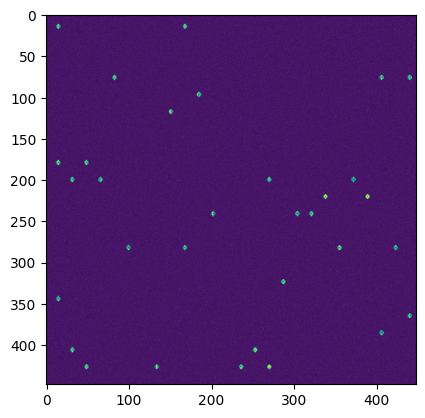

In [18]:
import matplotlib.pyplot as plt
plt.imshow(images_train[-100,0,:,:])
torch.min(images_train[-100,0,:,:])

In [21]:
# from ultralytics import YOLO

# # Load the pretrained YOLO model
# model = YOLO('yolov8n.pt')  # You can choose a different model variant if desired

# import torch
# import torch.nn as nn
# model.model.model[0].conv = nn.Conv2d(40, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
# model.model.model[-1].dfl = nn.Conv2d(16, 1000, kernel_size=(1, 1), stride=(1, 1), bias=False)
# model

In [14]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [23]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import gc
# from torch.optim.lr_scheduler import StepLR
# import torchvision as tv
# import timm
# device='cuda'
# # m1 = timm.create_model('regnety_016', in_chans=40, drop_path_rate=.0,num_classes=4000,pretrained=True)
# model=Patch_model()
# model.to(device)
# # Define your custom dataset

# class TestDataset2(Dataset):
#     def __init__(self, images):
#         self.images = images

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, index):
#         image = self.images[index]

#         return image.float()


# class TestDataset(Dataset):
#     def __init__(self, images, x):#x,y,scales):
#         self.images = images
#         self.x = x
#         # self.y = y
#         # self.scales = scales

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, index):
#         image = self.images[index,:,:,:]
#         #image  = tv.transforms.Resize(size=448)(image)
#         #image  = torch.tensor(image)
#         x = self.x[index,:]
#         # y = torch.tensor(self.y[index,:])
#         # scales1 = self.scales[index,0]
#         # scales2 = self.scales[index,1]
#         # scales3 = self.scales[index,2]
#         return image.float(), x.float()#,scales1.float(),scales2.float(),scales3.float()#,y.float(),  scales.float()
# import random
# class TrainDataset(Dataset):
#     def __init__(self, images, x):#x,y,scales):
#         self.images = images
#         self.x = x
#         # self.y = y
#         # self.scales = scales

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, index):
#         image = self.images[index,:,:,:]
#         #image  = tv.transforms.Resize(size=448)(image)
#         # if random.random() < 0.5:
#         #     scale_factor = random.uniform(.95, 1.05)
#         #     image *= scale_factor
#         if random.random() < 0.5:
#             image = image.flip(dims=[-1]) 
#         if random.random() < 0.5:
#             image = image.flip(dims=[-2])  # Assuming W=50 is the middle axis for flipping

#     # # Flip across the horiz
#ontal axis (H dimension) for input and label with a 50% chance
#         if random.random() < 0.5:
#             # # For input, assuming H=200 is the middle
#             image = image.flip(dims=[-3])  # Flipping the last dimension (H)
#             # # For label, assuming H=1000 is the middle
        

#         x = self.x[index,:]
#         # y = torch.tensor(self.y[index,:])
#         # scales1 = self.scales[index,0]
#         # scales2 = self.scales[index,1]
#         # scales3 = self.scales[index,2]
#         return image.float(), x.float()#,scales1.float(),scales2.float(),scales3.float()#,y.float(),  scales.float()


# # Define your model architecture

# import torch
# from torch.utils.data import DataLoader, Sampler
# import numpy as np



# # Assuming you have your grayscale images and labels loaded in memory
# from torch.optim.lr_scheduler import ExponentialLR
# # Create an instance of the custom dataset
# # x = torch.nan_to_num(xc_data).unsqueeze(dim=2)
# # y = torch.nan_to_num(yc_data).unsqueeze(dim=2)
# # x_test = torch.nan_to_num(xc_data3).unsqueeze(dim=2)
# # y_test = torch.nan_to_num(yc_data3).unsqueeze(dim=2)
# # coords = torch.cat((x,y), dim=2)
# # coords_test = torch.cat((x_test,y_test), dim=2)
# #images = images[0:14,:,:]
# # from sklearn.preprocessing import StandardScaler
# # scalerx = StandardScaler()
# # scalery = StandardScaler()
# # # xtorch=scalerx.fit_transform(xtorch)
# # # distr_torch=scalery.fit_transform(distr_torch)
# # maxs = torch.max(scales)
# # # mins = torch.min(scales)
# # # print(maxs,mins)
# # scales2 = (scales)/(maxs)
# # # scales2 = (scales-mins)/(maxs-mins)

# # maxs = torch.max(speeds)
# # mins = torch.min(speeds)
# # print(maxs)#,mins)
# # # scales_test2 = (scales_test)/(maxs)
# # speeds2 = (speeds/maxs)#-mins)/(maxs-mins)

# # # maxs = torch.max(speeds_test)
# # # mins = torch.min(speeds_test)
# # # print(maxs,mins)
# # # scales_test2 = (scales_test)/(maxs)
# # speeds_test2 = (speeds_test/maxs)#-mins)/(maxs-mins)
# # xtorch_test=scalerx.transform(xtorch_test)
# # distr_torch_test=scalery.transform(distr_torch_test)
# dataset = TrainDataset(images_train, speeds)#xtorch, distr_torch,scales2)


# # Create a dataloader
# batch_size = 32
# torch.cuda.empty_cache()
# gc.collect()
# #dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)
# # Create the GroupedSampler with a group size of 4
# #sampler = GroupedSampler(dataset, group_size=batch_size)
# #images3 = images3.unsqueeze(dim=0)
# # Create the DataLoader with the GroupedSampler
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,drop_last=False,num_workers=0)#,sampler=sampler)
# dataset_test = TestDataset(images_test,speeds_test)#  xtorch_test, distr_torch_test, scales_test2)
# batch_size = 10
# test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)

In [24]:
# dataset_test = TestDataset2(images)#  xtorch_test, distr_torch_test, scales_test2)
# batch_size = 10
# test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)

In [25]:
# images.shape

In [26]:
# device='cuda'
# model2 = Net0()
# model2.load_state_dict(torch.load('speed_model_Volo384_dispBrown_fullv2'))
# model2.to(device).eval()
# model2(torch.tensor(images[0:40]).to(device).float())

In [27]:
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from RAFT.core.update import BasicUpdateBlock, SmallUpdateBlock
# from RAFT.core.extractor import BasicEncoder, SmallEncoder
# from RAFT.core.corr import CorrBlock, AlternateCorrBlock
# from RAFT.core.utils.utils import bilinear_sampler, coords_grid, upflow8
# # from update import BasicUpdateBlock, SmallUpdateBlock
# # from extractor import BasicEncoder, SmallEncoder
# # from corr import CorrBlock, AlternateCorrBlock
# # from utils.utils import bilinear_sampler, coords_grid, upflow8

# try:
#     autocast = torch.cuda.amp.autocast
# except:
#     # dummy autocast for PyTorch < 1.6
#     class autocast:
#         def __init__(self, enabled):
#             pass
#         def __enter__(self):
#             pass
#         def __exit__(self, *args):
#             pass


# class RAFT2(nn.Module):
#     def __init__(self):
#         super(RAFT2, self).__init__()
#         #self.args = args

#         # if args.small:
#             # self.hidden_dim = hdim = 96
#             # self.context_dim = cdim = 64
#             # args.corr_levels = 4
#             # args.corr_radius = 3
        
#         # else:
        

#         # # feature network, context network, and update block
#         # if args.small:
#             # self.fnet = SmallEncoder(output_dim=128, norm_fn='instance', dropout=args.dropout)        
#             # self.cnet = SmallEncoder(output_dim=hdim+cdim, norm_fn='none', dropout=args.dropout)
#             # self.update_block = SmallUpdateBlock(self.args, hidden_dim=hdim)

#         # else:
#         hdim = 128
#         cdim = 128
#         corr_levels = 4
#         corr_radius = 4
#         self.fnet = BasicEncoder(output_dim=256, norm_fn='instance', dropout=.2)        
#         self.cnet = BasicEncoder(output_dim=hdim+cdim, norm_fn='batch', dropout=.2)
#         self.update_block = BasicUpdateBlock( corr_levels, corr_radius)
#         self.fc1 = nn.Linear(384,300)
#         self.fc2 = nn.Linear(300,40)
#         self.fc3 = nn.Linear(368640 ,500)

#     def freeze_bn(self):
#         for m in self.modules():
#             if isinstance(m, nn.BatchNorm2d):
#                 m.eval()

#     def initialize_flow(self, img):
#         """ Flow is represented as difference between two coordinate grids flow = coords1 - coords0"""
#         N, C, H, W = img.shape
#         coords0 = coords_grid(N, H//8, W//8, device=img.device)
#         coords1 = coords_grid(N, H//8, W//8, device=img.device)

#         # optical flow computed as difference: flow = coords1 - coords0
#         return coords0, coords1

#     def upsample_flow(self, flow, mask):
#         """ Upsample flow field [H/8, W/8, 2] -> [H, W, 2] using convex combination """
#         N, _, H, W = flow.shape
#         mask = mask.view(N, 1, 9, 8, 8, H, W)
#         mask = torch.softmax(mask, dim=2)

#         up_flow = F.unfold(8 * flow, [3,3], padding=1)
#         up_flow = up_flow.view(N, 2, 9, 1, 1, H, W)

#         up_flow = torch.sum(mask * up_flow, dim=2)
#         up_flow = up_flow.permute(0, 1, 4, 2, 5, 3)
#         return up_flow.reshape(N, 2, 8*H, 8*W)


#     def forward(self, image1, image2, iters=12, flow_init=None, upsample=True, test_mode=False):
#         """ Estimate optical flow between pair of frames """

#         image1 = 2 * (image1 / 255.0) - 1.0
#         image2 = 2 * (image2 / 255.0) - 1.0

#         image1 = image1.contiguous()
#         image2 = image2.contiguous()

#         corr_levels = 4
#         corr_radius = 4


#         alternate_corr = False
#         mixed_precision = False

#         hdim = 128
#         cdim = 128

#         # run the feature network
#         with autocast(enabled=mixed_precision):
#             fmap1, fmap2 = self.fnet([image1, image2])        
        
#         fmap1 = fmap1.float()
#         fmap2 = fmap2.float()
#         if alternate_corr:
#             corr_fn = AlternateCorrBlock(fmap1, fmap2, radius=corr_radius)
#         else:
#             corr_fn = CorrBlock(fmap1, fmap2, radius=corr_radius)

#         # run the context network
#         with autocast(enabled=mixed_precision):
#             cnet = self.cnet(image1)
#             net, inp = torch.split(cnet, [hdim, cdim], dim=1)
#             net = torch.tanh(net)
#             inp = torch.relu(inp)

#         coords0, coords1 = self.initialize_flow(image1)

#         if flow_init is not None:
#             coords1 = coords1 + flow_init

#         flow_predictions = []
#         for itr in range(iters):
#             coords1 = coords1.detach()
#             corr = corr_fn(coords1) # index correlation volume

#             flow = coords1 - coords0
#             with autocast(enabled=mixed_precision):
#                 net, up_mask, delta_flow = self.update_block(net, inp, corr, flow)

#             # F(t+1) = F(t) + \Delta(t)
#             coords1 = coords1 + delta_flow

#             # upsample predictions
#             if up_mask is None:
#                 flow_up = upflow8(coords1 - coords0)
#             else:
#                 flow_up = self.upsample_flow(coords1 - coords0, up_mask)
            
#             flow_predictions.append(flow_up)

#         if test_mode:
#             return coords1 - coords0, flow_up
#         flow_predictions = torch.cat(flow_predictions)
#         flow_predictions = F.relu(self.fc1(flow_predictions))
#         flow_predictions = torch.squeeze(flow_predictions)
#         flow_predictions = F.relu(self.fc2(flow_predictions))
#         flow_predictions = torch.reshape(flow_predictions,[2,368640])
#        # print(flow_predictions.shape)
#         flow_predictions = self.fc3(flow_predictions)
        
            
#         return flow_predictions


In [52]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        l=40
        #self.fc2=nn.Conv2d(100, l, 1, stride=2)
        self.fc1 = nn.Linear(256,l)
        self.fc2 = nn.Linear(256,l)
        
        self.fc3 = nn.Linear(64000,8000)
        #self.b1 = nn.BatchNorm1d(8000)
        self.fc4 = nn.Linear(8000,6000)
        self.fc5 = nn.Linear(6000,4000)
        self.fc6 = nn.Linear(4000,2000)
        self.fc7 = nn.Linear(2000,1000)
        self.fc8 = nn.Linear(1000,500)
        self.fc9 = nn.Linear(500,500)

    def forward(self, x):
        b = x.shape[0]
        x = F.gelu(self.fc1(x))
        x = x.permute(0,1,3,2)
        x = F.gelu(self.fc2(x))
        x = x.reshape(b, -1)
        x = F.gelu(self.fc3(x))
        #x = self.b1(x)
        x = F.gelu(self.fc4(x))
        x = F.gelu(self.fc5(x))
        x = F.gelu(self.fc6(x))
        x = F.gelu(self.fc7(x))
        x = F.gelu(self.fc8(x))
        x = (self.fc9(x))

        return x

In [35]:
40*40*40

64000

In [22]:
import gc
torch.cuda.empty_cache()
gc.collect()

485

In [22]:
# model=RAFT2()
# device='cuda'
# model.to(device)
# model
model

Patch_model(
  (m1): VOLO(
    (patch_embed): PatchEmbed(
      (conv): Sequential(
        (0): Conv2d(40, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
      )
      (proj): Conv2d(128, 384, kernel_size=(4, 4), stride=(4, 4))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (network): ModuleList(
      (0): Sequential(
        (0): Outlooker(
          (norm1): LayerNorm((384,), eps=1e-05, elementwise_

In [63]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gc
from torch.optim.lr_scheduler import StepLR
import torchvision as tv
import timm
device='cuda'
# swinv2_small_window16_256
# vit_so150m_patch16_reg4_gap_256
# maxxvitv2_nano_rw_256
# levit_conv_256d
#model = timm.create_model('volo_d3_448', in_chans=40,drop_path_rate=.4, num_classes=500,pretrained=True)
# # m1 = timm.create_model('regnety_016', in_chans=40, drop_path_rate=.0,num_classes=4000,pretrained=True)
#model=Patch_model()
#model.to(device)
torch.cuda.empty_cache()
gc.collect()
# Define your custom dataset
class TestDataset(Dataset):
    def __init__(self, images, x):#x,y,scales):
        self.images = images
        self.x = x
        # self.y = y
        # self.scales = scales

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index,:,:,:]
        #image  = tv.transforms.Resize(size=448)(image)
        #image  = torch.tensor(image)
        x = self.x[index,:]
        # y = torch.tensor(self.y[index,:])
        # scales1 = self.scales[index,0]
        # scales2 = self.scales[index,1]
        # scales3 = self.scales[index,2]
        return image.float(), x.float()#,scales1.float(),scales2.float(),scales3.float()#,y.float(),  scales.float()
import random
class TrainDataset(Dataset):
    def __init__(self, images, x):#x,y,scales):
        self.images = images
        self.x = x
        # self.y = y
        # self.scales = scales

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index,:,:,:]
        #image  = tv.transforms.Resize(size=448)(image)
        # if random.random() < 0.5:
        #     scale_factor = random.uniform(.95, 1.05)
        #     image *= scale_factor
        if random.random() < 0.5:
            image = image.flip(dims=[-1]) 
        if random.random() < 0.5:
            image = image.flip(dims=[-2])  # Assuming W=50 is the middle axis for flipping

    # # Flip across the horizontal axis (H dimension) for input and label with a 50% chance
        if random.random() < 0.5:
        #     # # For input, assuming H=200 is the middle
            image = image.flip(dims=[-3])  # Flipping the last dimension (H)
        #     # # For label, assuming H=1000 is the middle
        

        x = self.x[index,:]
        # y = torch.tensor(self.y[index,:])
        # scales1 = self.scales[index,0]
        # scales2 = self.scales[index,1]
        # scales3 = self.scales[index,2]
        return image.float(), x.float()#,scales1.float(),scales2.float(),scales3.float()#,y.float(),  scales.float()


# Define your model architecture

import torch
from torch.utils.data import DataLoader, Sampler
import numpy as np



# Assuming you have your grayscale images and labels loaded in memory
from torch.optim.lr_scheduler import ExponentialLR
# Create an instance of the custom dataset
# x = torch.nan_to_num(xc_data).unsqueeze(dim=2)
# y = torch.nan_to_num(yc_data).unsqueeze(dim=2)
# x_test = torch.nan_to_num(xc_data3).unsqueeze(dim=2)
# y_test = torch.nan_to_num(yc_data3).unsqueeze(dim=2)
# coords = torch.cat((x,y), dim=2)
# coords_test = torch.cat((x_test,y_test), dim=2)
#images = images[0:14,:,:]
# from sklearn.preprocessing import StandardScaler
# scalerx = StandardScaler()
# scalery = StandardScaler()
# # xtorch=scalerx.fit_transform(xtorch)
# # distr_torch=scalery.fit_transform(distr_torch)
# maxs = torch.max(scales)
# # mins = torch.min(scales)
# # print(maxs,mins)
# scales2 = (scales)/(maxs)
# # scales2 = (scales-mins)/(maxs-mins)

# maxs = torch.max(speeds)
# #mins = torch.min(speeds)
# print(maxs)#,mins)
# #scales_test2 = (scales_test)/(maxs)
# speeds2 = (speeds/maxs)#-mins)/(maxs-mins)

# # maxs = torch.max(speeds_test)
# # mins = torch.min(speeds_test)
# # print(maxs)#,mins)
# # # scales_test2 = (scales_test)/(maxs)
# speeds_test2 = (speeds_test/maxs)#-mins)/(maxs-mins)
# xtorch_test=scalerx.transform(xtorch_test)
# distr_torch_test=scalery.transform(distr_torch_test)
dataset = TrainDataset(images_train, speeds)#xtorch, distr_torch,scales2)


# Create a dataloader
batch_size = 8
torch.cuda.empty_cache()
gc.collect()
#dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)
# Create the GroupedSampler with a group size of 4
#sampler = GroupedSampler(dataset, group_size=batch_size)
#images3 = images3.unsqueeze(dim=0)
# Create the DataLoader with the GroupedSampler
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,drop_last=False,num_workers=0)#,sampler=sampler)
dataset_test = TestDataset(images_test,speeds_test)#  xtorch_test, distr_torch_test, scales_test2)
batch_size = 8
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)
# model = Net().to(device)
# model2 = Net2().to(device)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(),lr=0.0001,weight_decay=.001)
#optimizer2 = optim.Adam(model2.parameters(), lr=0.00001)
gamma = .9998# The exponential decay factor (adjust as needed)
#scheduler1 = CosineAnnealingWarmRestarts(optimizer1, 200, 2)
scheduler = ExponentialLR(optimizer, gamma=gamma)
torch.cuda.empty_cache()
gc.collect()

# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for im,speed in dataloader:
        # Forward pass
        optimizer.zero_grad()
        outputs = model(im.to(device))
       # outputs = torch.sort(outputs).values
        #outputs = (out1+out2+out3)/3
        #outputs2 = model2(outputs.to(device))
        # loss_xt = criterion(outputs[:,0,:].squeeze(), xt.squeeze().to(device))
        # loss_lab = criterion(outputs[:,1,:].squeeze(), lab.squeeze().to(device))
        # loss = criterion(outputs.squeeze(), scale.squeeze().to(device))
        #loss_end = criterion(outputs[:,-10:], speed[:,-10:].to(device))
        loss_mse = criterion(outputs.squeeze(), speed.to(device))
        # ls1 = criterion(out1.squeeze(1), scale1.to(device))
        # ls2 = criterion(out2.squeeze(1), scale2.to(device))
        # ls3 = criterion(out3.squeeze(1), scale3.to(device))
        #loss = loss_lab+loss_xt
        # Backward pass and optimization
        
        #optimizer2.zero_grad()
        loss = loss_mse#+.1*loss_end#+(ls1+ls2+ls3)*3
        loss.backward()
        optimizer.step()
        #optimizer2.step()
        scheduler.step()

        running_loss += loss.item()

    # Print the average loss for the epoch
    epoch_loss = running_loss / len(dataloader)
    model.eval()
    running_loss2=0
    #running_loss3=0
    with torch.no_grad():
        for im_tst,speed_tst in test_dataloader:
        # Forward pass
            outputs_tst = model(im_tst.to(device))
            #out2 = RAFT(im_tst[:,12:15,:,:].to(device), im_tst[:,15:18,:,:].to(device))
            #out3 = RAFT(im_tst[:,30:33,:,:].to(device), im_tst[:,36:39,:,:].to(device))
           # outputs_tst = (out1+out2+out3)/3
            #outputs_tst = RAFT(im_tst[:,0:3,:,:].to(device), im_tst[:,6:9,:,:].to(device))
            # loss_xt = criterion(outputs_tst[:,0,:].squeeze(), xt_tst.squeeze().to(device))
            # loss_lab = criterion(outputs_tst[:,1,:].squeeze(), lab_tst.squeeze().to(device))
            # loss2 = criterion(outputs_tst.squeeze(), scale_tst.squeeze().to(device))
            # ls1 = criterion(a_tst.squeeze(1), s1.to(device))
            # ls2 = criterion(b_tst.squeeze(1), s2.to(device))
            # ls3 = criterion(c_tst.squeeze(1), s3.to(device))
            loss2 = criterion(outputs_tst.squeeze(), speed_tst.to(device))
            #loss3 = (ls1+ls2+ls3)
            #loss2 = loss_lab+loss_xt

#             loss2 = criterion(outputs_tst.squeeze(), scale_tst.squeeze().to(device))

            running_loss2 += loss2.item()
            #running_loss3 += loss3.item()
    epoch_loss2 = running_loss2 / len(test_dataloader)
    #epoch_loss3 = running_loss3 / len(test_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f},  Test Loss: {epoch_loss2:.5f},Learning Rate: {optimizer.param_groups[0]['lr']:.7f}")
    #, Test Loss Distribution Params: {epoch_loss3:.5f}
    torch.cuda.empty_cache()
    gc.collect()
print("Training finished!")

Epoch [1/300], Loss: 17.89907,  Test Loss: 18.25912,Learning Rate: 0.0000986
Epoch [2/300], Loss: 15.18039,  Test Loss: 15.81715,Learning Rate: 0.0000972
Epoch [3/300], Loss: 13.54753,  Test Loss: 14.56370,Learning Rate: 0.0000959
Epoch [4/300], Loss: 13.79942,  Test Loss: 13.67061,Learning Rate: 0.0000946
Epoch [5/300], Loss: 12.12175,  Test Loss: 11.78340,Learning Rate: 0.0000932
Epoch [6/300], Loss: 10.51403,  Test Loss: 11.53087,Learning Rate: 0.0000919
Epoch [7/300], Loss: 10.74347,  Test Loss: 12.38551,Learning Rate: 0.0000907
Epoch [8/300], Loss: 10.36057,  Test Loss: 11.33447,Learning Rate: 0.0000894
Epoch [9/300], Loss: 10.56483,  Test Loss: 10.37865,Learning Rate: 0.0000882
Epoch [10/300], Loss: 9.30354,  Test Loss: 12.86914,Learning Rate: 0.0000869
Epoch [11/300], Loss: 9.89992,  Test Loss: 8.20380,Learning Rate: 0.0000857
Epoch [12/300], Loss: 7.86660,  Test Loss: 7.32847,Learning Rate: 0.0000845
Epoch [13/300], Loss: 7.43355,  Test Loss: 7.01229,Learning Rate: 0.0000834
Ep

In [28]:
outputs

tensor([[ 0.0044,  0.0015,  0.0028,  ...,  0.1477,  0.1621,  0.2417],
        [ 0.0025,  0.0203,  0.0004,  ...,  0.1412,  0.1524,  0.1897],
        [ 0.0037,  0.0119, -0.0031,  ...,  0.2473,  0.2741,  0.3752],
        ...,
        [ 0.0180, -0.0067,  0.0016,  ...,  0.0297,  0.0346,  0.0460],
        [ 0.0050, -0.0082,  0.0038,  ...,  0.2047,  0.2285,  0.2937],
        [-0.0023,  0.0153,  0.0046,  ...,  0.2567,  0.2724,  0.3658]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
scales

In [ ]:
criterion(outputs_tst, speed_tst.to(device))

In [ ]:
outputs_tst

In [ ]:
model1 = Net0()
model1.load_state_dict(torch.load('speed_model_Volo448_dispBrown_full'))
model1.to(device).eval()

model2 = Net2()
model2.load_state_dict(torch.load('speed_model_Volo384_dispBrown_fullv2'))
model2.to(device).eval()

model3 = Net2()
model3.load_state_dict(torch.load('speed_model_Volo384_dispBrown_fullv3'))
model3.to(device).eval()

VOLO(
  (patch_embed): PatchEmbed(
    (conv): Sequential(
      (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (proj): Conv2d(64, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (network): ModuleList(
    (0): Sequential(
      (0): Outlooker(
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): OutlookAttention(
          (v): Linear

In [24]:
# model.eval()
# ground_truth=[]
# preds=[]
# losses=[]
# with torch.no_grad():
#     for im_tst,speed_tst in test_dataloader:
#     # Forward pass
#         outputs_tst = model(im_tst.to(device))
#         #loss2 = criterion(outputs_tst, speed_tst.to(device))
#         out_vecs=[]
#         for k in range(len(outputs_tst)):
#             out = outputs_tst[k,:].cpu().detach().squeeze()
#             #
            
#             def rolling_mean(matrix, window):
#                 df = pd.DataFrame(matrix)
#                 return df.rolling(window=window).mean().dropna().to_numpy()
#             out_mean = rolling_mean(out,3)
#             #out_mean=out_mean[out_mean>0]
#             out_mean[out_mean<0]=0.0001
#             out_vecs.append(out_mean)
#        # losses.append(loss2.item())
#         preds.append(out_vecs)
#         ground_truth.append(speed_tst.numpy())

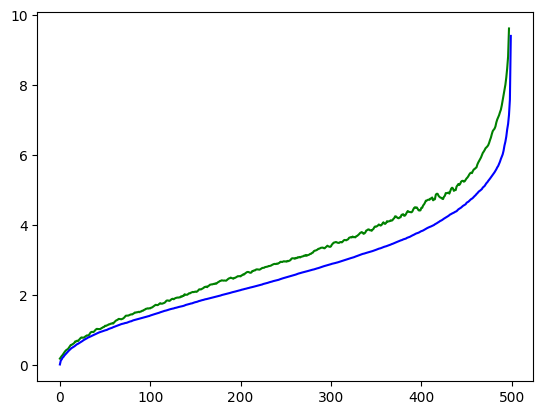

In [25]:
#k=8
model.eval()
ground_truth=[]
preds=[]
losses=[]
with torch.no_grad():
    for im_tst,speed_tst in test_dataloader:
    # Forward pass
        outputs_tst = model(im_tst.to(device))
        #loss2 = criterion(outputs_tst, speed_tst.to(device))
        out_vecs=[]
        for k in range(len(outputs_tst)):
            out = outputs_tst[k,:].cpu().detach().squeeze()
            #
            
            def rolling_mean(matrix, window):
                df = pd.DataFrame(matrix)
                return df.rolling(window=window).mean().dropna().to_numpy()
            out_mean = rolling_mean(out,3)
            #out_mean=out_mean[out_mean>0]
            out_mean[out_mean<0]=0.0001
            out_vecs.append(out_mean)
       # losses.append(loss2.item())
        preds.append(out_vecs)
        ground_truth.append(speed_tst.numpy())
    # for i in out:
#     if (i>.03)&(count<400):
#         out[:,count
#     count+=1
plt.plot(out_mean, c='g')
plt.plot(speed_tst[k], c='b')

In [41]:
import timm
#timm.list_models()

In [ ]:
preds_mean = (preds1+preds2+preds3)
len(preds1[7])

In [ ]:
len(pred)
len(ground_truth[i][j,4:-3])
torch.tensor(pred)

5.4011844246919924

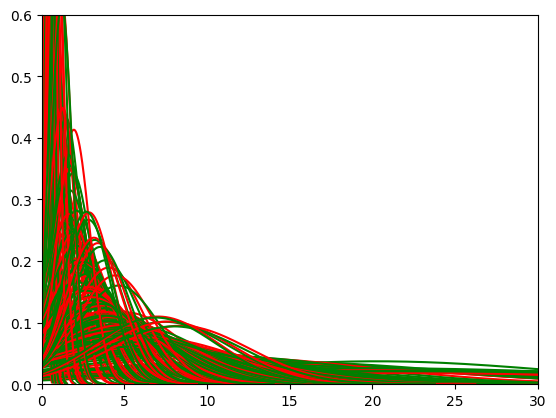

In [26]:
len(preds)
from scipy.stats import norm

losses=[]
full_preds=[]
criterion = nn.MSELoss()
#ground_truth[-1].shape
for i in range(len(preds)):
    for j in range(len(preds[i])):
        pred = preds[i][j]#(.00*preds1[i][j]+0.3*preds2[i][j]+.7*preds3[i][j])
        a,b = norm.fit(pred)

        xtorch= np.linspace(norm.ppf(0.0001, a,b),
                        norm.ppf(0.9999, a,b), target_length)
        distr_torch=norm.pdf(xtorch, a,b)
        plt.plot(xtorch,distr_torch,c='r')
        
        a,b = norm.fit(ground_truth[i][j,:])
        xtorch= np.linspace(norm.ppf(0.0001, a,b),
                        norm.ppf(0.9999, a,b), target_length)
        distr_torch=norm.pdf(xtorch, a,b)
        plt.plot(xtorch,distr_torch,c='g')
        plt.xlim([0,30])
        plt.ylim([0,.6])
        full_preds.append(pred)
        loss = criterion(torch.tensor(pred).squeeze(), torch.tensor(ground_truth[i][j,:-2]))
        losses.append(loss.item())
        #plt.title('Loss = '+str(loss.item()))
        #plt.show()
        
np.mean(losses)
#ground_truth[0].shape

Text(0.5, 1.0, 'Loss = 0.3535454836161208')

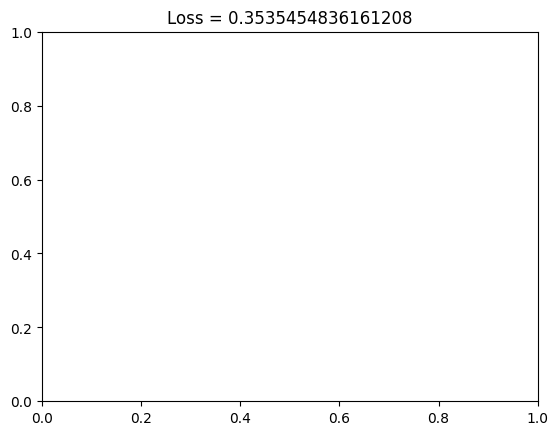

In [30]:
plt.title('Loss = '+str(loss.item()))

In [27]:
flat_pred = np.vstack(full_preds)
flat_pred=np.reshape(flat_pred,[-1,])
flat_pred.shape

(69222,)

In [28]:
flat_gt = np.vstack(ground_truth)
flat_gt=np.reshape(flat_gt,[-1,])
flat_gt.shape

(69500,)

In [32]:
model

VOLO(
  (patch_embed): PatchEmbed(
    (conv): Sequential(
      (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (proj): Conv2d(64, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (network): ModuleList(
    (0): Sequential(
      (0): Outlooker(
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): OutlookAttention(
          (v): Linear

In [29]:
torch.save(model.state_dict(), 'speed_model_volod3_448px_disp300_4_25')

In [65]:
model

ByobNet(
  (stem): Stem(
    (conv1): ConvNormAct(
      (conv): Conv2d(40, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (conv2): ConvNormAct(
      (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (conv3): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


4.002816571771019
1.3492818098737265 -0.11670318679423722 2.7702379486915296
4.133819509298572
1.3418002 -0.07041723653577822 2.8624365


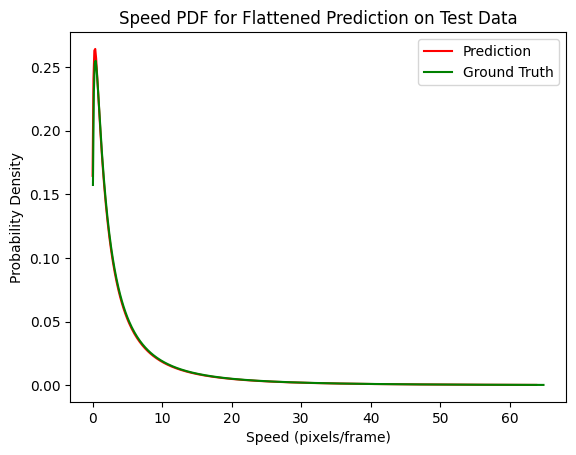

In [20]:
a,b,c = lognorm.fit(flat_pred)
#c=c+.4
#a=a+.1
# Generate points for plotting the fitted distribution
xtorch= np.linspace(lognorm.ppf(0.01, a,b,c),
                lognorm.ppf(0.99, a,b,c), target_length)

distr_torch=lognorm.pdf(xtorch, a,b,c)
print(a+b+c)
print(a,b,c)
# scales[i,:] = torch.tensor([a,b,c])
plt.plot(xtorch,distr_torch,c='r')

# a = (3*a_tst[k].cpu().detach().numpy()+a)/4
# b = (3*b_tst[k].cpu().detach().numpy()+b)/4
# c = (3*c_tst[k].cpu().detach().numpy()+c)/4
# print(a+b+c)
# print(a,b,c)
# xtorch= np.linspace(lognorm.ppf(0.01, a,b,c),
#                 lognorm.ppf(0.99, a,b,c), target_length)

# distr_torch=lognorm.pdf(xtorch, a,b,c)
# print(a,b,c)
# # scales[i,:] = torch.tensor([a,b,c])
# plt.plot(xtorch,distr_torch,c='b')

a,b,c = lognorm.fit(flat_gt)
    
# Generate points for plotting the fitted distribution
xtorch= np.linspace(lognorm.ppf(0.01, a,b,c),
                lognorm.ppf(0.99, a,b,c), target_length)

distr_torch=lognorm.pdf(xtorch, a,b,c)
print(a+b+c)
print(a,b,c)

# scales[i,:] = torch.tensor([a,b,c])
plt.plot(xtorch,distr_torch,c='g')
plt.title('Speed PDF for Flattened Prediction on Test Data')
plt.xlabel('Speed (pixels/frame)')
plt.ylabel('Probability Density')
plt.legend(['Prediction', 'Ground Truth'])


In [ ]:
(a_tst[k].cpu().detach().numpy()+a)/2

In [ ]:
(b_tst[k].cpu().detach().numpy()+b)/2

In [ ]:
(c_tst[k].cpu().detach().numpy()+c)/2

In [ ]:
# [ 1.2188,  0.0247, 11.8741]
# [1.2127, 0.0080, 6.0299]
# [1.2127, 0.0316, 6.0299]
s1 = scale_tst[:,0]#*1.2127
s2 = scale_tst[:,1]#*0.0316
s3 = scale_tst[:,2]#*6.0299

out1 = outputs_tst.cpu().detach().numpy()[:,0]#*1.2127
out2 = outputs_tst.cpu().detach().numpy()[:,1]#*0.0316
out3 = outputs_tst.cpu().detach().numpy()[:,2]#*6.0299


In [ ]:
k=0
x_shape= torch.tensor(np.linspace(lognorm.ppf(0.01, out1[k], out2[k], out3[k]),
                    lognorm.ppf(0.99,  out1[k], out2[k], out3[k]), 100))

x_distr=torch.tensor(lognorm.pdf(x_shape,  out1[k], out2[k], out3[k]))

In [ ]:
x_shape_or= torch.tensor(np.linspace(lognorm.ppf(0.01, s1[k], s2[k], s3[k]),
                    lognorm.ppf(0.99,  s1[k], s2[k], s3[k]), 100))

x_distr_or=torch.tensor(lognorm.pdf(x_shape,  s1[k], s2[k], s3[k]))

In [ ]:
plt.scatter(x_shape,x_distr)
plt.scatter(x_shape_or,x_distr_or)

In [ ]:
plt.scatter(xt.cpu().detach().numpy(),lab.cpu().detach().numpy())
plt.scatter(outputs[0].cpu().detach().numpy(),outputs[1].cpu().detach().numpy())

In [ ]:
torch.save(model.state_dict(), 'weights_3_9_2')

In [ ]:
dataset_test = CustomDataset(images3, coords_test)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=True)
model.eval()
running_loss2=0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        #labels= labels.to(device)
        #lab = torch.mean(lab, dim=(2,3)).squeeze()

        outp = model(inputs)  
        test_loss = criterion(outp, labels.to(device))
        running_loss2 += test_loss.item()
epoch_loss2 = running_loss2 / len(test_dataloader)
epoch_loss2

In [ ]:
# next(iter(dataloader))
ina.shape

In [ ]:
outp



In [ ]:
for i in range(672):
    print(torch.nan_to_num(xc_data[0:14,i]))

In [ ]:
np_out = np.array(outp.cpu().detach())
np_out[np_out<=20]=np.nan
np_out.shape


In [ ]:
np_lab = np.array(labels.detach())
np_lab[np_lab==0]=np.nan


In [ ]:
np_lab

In [ ]:
for i in range(np_out.shape[0]):
    plt.scatter(np_out[i,:,0],np_out[i,:,1])

In [ ]:
for i in range(np_lab.shape[0]):
    plt.scatter(np_lab[i,:,0],np_lab[i,:,1])

In [ ]:
for i in range(np_lab.shape[1]):
    plt.plot(np_lab[:,i,0],np_lab[:,i,1])

In [ ]:
for i in range(np_out.shape[1]):
    plt.plot(np_out[:,i,0],np_out[:,i,1])

In [ ]:
plt.plot(np_lab[:,i,0],np_lab[:,i,1])
plt.plot(np_out[:,i,0],np_out[:,i,1])

In [ ]:
np_out[:,i,0]

In [ ]:
np_out[:,i,1]

In [ ]:
lab[:,0,0]